# Global Active Learning

**Author**: Benjamin Urben<br>
**Email**: burben@student.ethz.ch / benjamin.urben@hotmail.ch<br>
**Context**: Master Thesis on "Use of Conditional Variational Autoencoder (cVAE) in the design of connections"<br>
**Institution**: ETH Zürich, Institute of Structural Engineering (IBK)

**Description**:

Active Learning workflow for increasing the training data of a DNN. Incorporates an API to automatically generate FEM calculations with IDEA Statica. 

*Global* Active Learning refers to adding data with new designs. 

**IMPORTANT**: Change `idea_path` variable in `API.py` to the path of IDEA Statica

**Dependencies**: 
- `Datareader.py`
- `Settings.py`
- `DNN.py`
- `Saved Models\DNN_Model_Full_V2`
- `AL_API\API.py`
- `AL_API\Corner_Stiff_Wid.ideaCon`
- `AL_API\Corner_Stiff2_Wid.ideaCon`
- `AL_API\Corner.ideaCon`
- `AL_API\Corner_Stiffner.ideaCon`

**Generates**:
- `Data\Extended_Database.csv`
- `Saved Models\DNN_Model_AL_Finetuned\DNN_Model_AL_Finetuned.pth`






## Setup

### Import

In [1]:
import os
import importlib
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
import pandas as pd
import copy
import math
import random
import time
import pickle

from scipy.interpolate import interp1d
from scipy.stats import binned_statistic_2d
from scipy.stats import linregress
from sklearn.preprocessing import StandardScaler
from sklearn.metrics.pairwise import euclidean_distances
import torch

os.chdir(os.path.dirname(os.getcwd()))
from Settings import Directory, Plotting_Parameters
from DataReader import DataReader
from DNN import DNN
from Plot_Functions import plot_MV_interaction
from Plot_Functions import find_similar_profiles

import warnings
warnings.filterwarnings('ignore')

Root Directory set to:  c:\Users\benja\OneDrive\Desktop\Masterarbeit\Code\10_Neural_Networks


In [2]:
plot_params = Plotting_Parameters()
directory = Directory()

Root Directory set to:  c:\Users\benja\OneDrive\Desktop\Masterarbeit\Code\10_Neural_Networks


In [3]:
datareader = DataReader()

Root Directory set to:  c:\Users\benja\OneDrive\Desktop\Masterarbeit\Code\10_Neural_Networks
df_full_filtered.csv
Extended_Database.csv
Extended_Database_FilterOn.csv
extended_profiles_filteron_iter_1.csv
extended_profiles_iter_1.csv
extended_profiles_iter_2.csv
extended_profiles_iter_3.csv
Knee_Connection_Output_red.csv
Knee_parallel_I_Off0_Output_red_Q1.xlsx
Knee_parallel_I_Off0_Output_red_Q4.xlsx
Knee_parallel_I_Output_Q1.xlsx
Knee_parallel_I_Output_red_Q4.xlsx
Knee_perpendicular_n.stiff_Off0_Output_red_Q1.xlsx
Knee_perpendicular_n.stiff_Off0_Output_red_Q4.xlsx
Knee_perpendicular_n.stiff_Output_red_Q1.xlsx
Knee_perpendicular_n.stiff_Output_red_Q4.xlsx
Knee_widener_I_Output_Off0_red_Q1.xlsx
Knee_widener_I_Output_red_Q1.xlsx
_OLD


### Load Data

In [4]:
df_full = datareader.load('Knee_Connection_Output_red.csv')

Knee_Connection_Output_red.csv: (714385, 53)


### Load Forward Model

In [5]:
model = DNN()

model_name = "DNN_Model_Full_V2"
MODEL_SAVE_PATH = os.path.join("Saved Models", model_name)
MODEL_SAVE_FILE = os.path.join(MODEL_SAVE_PATH, f"{model_name}.pth")
                               
model = torch.load(MODEL_SAVE_FILE)
df = df_full.loc[model.data['data_indeces']]

for key, value in model.config.items():
    print(key, value)

batch_size 256
epochs 3000
learning_rate 0.001
test_size 0.1
val_size 0.1
print_logs True
dropout_prob 0.0
num_layers 3
neurons_per_layer [128, 64, 32, 16, 8]
use_batch_norm True
seed 42
description Use larger network architecture and more features as training data. Also use Batch normalization


### Generate (or load) data uncertainties

#### Generate

In [6]:
#mcd_mean_full, mcd_std_full, _ = model.mc_dropout_uncertainty(df_full, num_samples=200)

In [7]:
#uncertainty_full = mcd_std_full / mcd_mean_full
#np.save(r"Saved Variables\uncertainty_fulldf.npy", uncertainty_full)

#### Load

In [8]:
uncertainty_full = np.load(r"Saved Variables\uncertainty_fulldf.npy").flatten()

## Illustrate workflow

### 1. Find most uncertain profiles

In [9]:
most_uncertain_samples = np.argsort(uncertainty_full)[-10:]
df_most_uncertain = df_full.loc[most_uncertain_samples]

In [10]:
y_preds, _ = model.predict(df_full)
y_truths = df_full['target'].values

In [11]:
rel_error = (y_truths-y_preds.numpy().flatten())/ y_truths

In [12]:
most_error_samples = np.argsort(np.abs(rel_error))[-10:]
df_most_error = df_full.loc[most_error_samples]

In [13]:
uncertainty_full = rel_error

Define geometric & material features, which define a profile. (No loads)

In [14]:
fixed_features = model.features.copy()
fixed_features.remove('M_contribution')
fixed_features.remove('V_contribution')

Taking the most uncertain values is not a good strategy, since most of them will be from the same profile (different load combinations).

In [15]:
df_most_uncertain[fixed_features].duplicated(keep=False)

71617     True
71615     True
71965    False
71619     True
71553    False
74197     True
71616     True
74199     True
71618     True
71879    False
dtype: bool

Instead form groups according to the profile dimensions (identical geometry/material, different load combinations).

In [16]:
identical_groups = df[fixed_features].groupby(list(df[fixed_features].columns)).apply(lambda x: x.index.tolist()).tolist()
print(f"Number of identical groups: {len(identical_groups)}")

Number of identical groups: 152259


Get the max uncertainty for each group:

In [17]:
group_uncertainty = np.array([uncertainty_full[group].max() for group in identical_groups])

Get the n most uncertain groups:

In [18]:
most_uncertain_groups = np.argsort(group_uncertainty)[-10:]

Most uncertain group of profiles:

In [19]:
most_uncertain_group_ids = identical_groups[most_uncertain_groups[0]]

Select one profile of the group to serve as a template (does not matter which, since all have identical features):

In [20]:
base_id = most_uncertain_group_ids[0]

base_profile = df_full.iloc[base_id:base_id+1].copy()
group_profiles = df_full.iloc[most_uncertain_group_ids].copy()
group_uncertainty = uncertainty_full[most_uncertain_group_ids]

### 2. Get new load combination

Function to find the location (M/V contribution) of new load combinations, based on the location and uncertainty of existing points.

In [21]:
def find_optimal_location(V_cont, uncertainty):
    angles = np.arcsin(V_cont) / (np.pi / 2)
    if uncertainty.max() - uncertainty.min() == 0:
        uncertainty_normalized = (uncertainty - uncertainty.min())
    else:
        uncertainty_normalized = (uncertainty - uncertainty.min()) / (uncertainty.max() - uncertainty.min())

    sorted_indices = np.argsort(angles)
    angles_sorted = angles[sorted_indices]
    uncertainty_sorted = uncertainty_normalized[sorted_indices]

    if 0 not in angles_sorted:
        angles_sorted = np.insert(angles_sorted, 0, 0)
        uncertainty_sorted = np.insert(uncertainty_sorted, 0, uncertainty_sorted[0])

    if 1 not in angles_sorted:
        angles_sorted = np.append(angles_sorted, 1)
        uncertainty_sorted = np.append(uncertainty_sorted, uncertainty_sorted[-1])

    interp_func = interp1d(angles_sorted, uncertainty_sorted, kind='linear')
    x = np.linspace(0, 1, 100)
    uncertainty_interpolated = interp_func(x)

    min_distance = lambda new_point, existing_points: np.min(np.abs(existing_points - new_point))
    distance_penalty = np.array([min_distance(xi, angles[sorted_indices]) for xi in x])
    objective = uncertainty_interpolated * distance_penalty

    return x[np.argmax(objective)]

def get_MV_contribution(ratio):
    M_contribution = np.cos(ratio * (np.pi / 2))
    V_contribution = np.sin(ratio * (np.pi / 2))
    return M_contribution, V_contribution

In [22]:
ratio = find_optimal_location(group_profiles['V_contribution'].values, group_uncertainty) # M or V needed?
M_contribution, V_contribution = get_MV_contribution(ratio)

new_profile = base_profile.copy()
new_profile['M_contribution'] = round(M_contribution,6)
new_profile['V_contribution'] = round(V_contribution,6)

print(f"Optimal ratio: {ratio}")
print(f"Optimal M_contribution: {M_contribution}")
print(f"Optimal V_contribution: {V_contribution}")

Optimal ratio: 0.48484848484848486
Optimal M_contribution: 0.7237340381050702
Optimal V_contribution: 0.6900790114821119


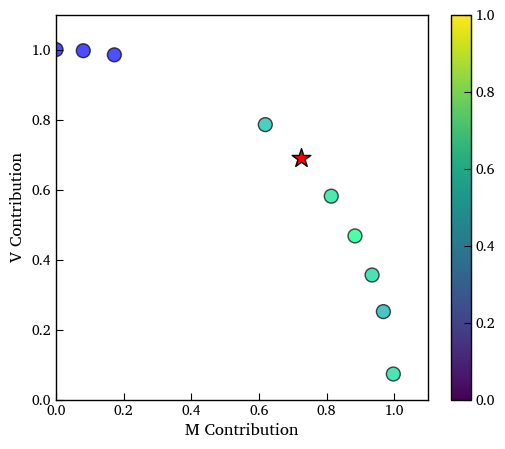

In [23]:
fig, ax = plt.subplots(figsize=(6,5))

plt.scatter(group_profiles['M_contribution'], group_profiles['V_contribution'],
            c=group_uncertainty, cmap='winter', s=100, edgecolor='black', alpha=0.7)

plt.scatter(new_profile['M_contribution'], new_profile['V_contribution'],
            c='red', s=200, edgecolor='black', label='New Profile', marker='*')

plt.xlabel('M Contribution')
plt.ylabel('V Contribution')
plt.xlim(0, 1.1)
plt.ylim(0, 1.1)

plt.colorbar()

plt.show()

In [24]:
current_id = len(df_full)

new_profile.index = [current_id]
new_profile['M_Rd'] = None
new_profile['V_Rd'] = None
new_profile['M'] = None
new_profile['V'] = None
new_profile['proz'] = None

This is the resulting profile. The geometric and material features are taken from the base profile (template), only the load combination is novel. 

In [25]:
new_profile

,Profile_x,h_x,b_x,tw_x,tf_x,A_x,Av_x,Iy_x,Wely_x,Wply_x,...,M_Rd,V_Rd,V_contribution,M_contribution,V_norm,M_norm,target,Cat_h,Cat_t_stiffc,cost
714385,HEA140,133,140,5.5,8.5,3141.610658,1012.360658,10330000,155400.0,173500,...,None,None,0.690079,0.723734,0.049662,0.678079,0.679895,0,1,NaN


Convert `M_contribution`and `V_contribution`to loads $M$ and $V$:

In [26]:
def get_MV(profile):
    Mplx = profile['Mpl_x']
    Mply = profile['Mpl_y']
    Vplx = profile['Vpl_x']
    Vply = profile['Vpl_y']
    V_cont = profile['V_contribution']
    M_cont = profile['M_contribution']

    ratio = V_cont / (M_cont +1e-12)
    Vmax = np.max([Vplx, Vply])
    Mmax = np.max([Mplx, Mply])
    Mnorm = Mmax / Mply
    Vnorm = Vmax / Vply
    
    M = Vnorm / (ratio + Vnorm / Mnorm)
    V = ratio * M

    profile['M'] = M*Mply
    profile['V'] = V*Vply

In [27]:
get_MV(new_profile)

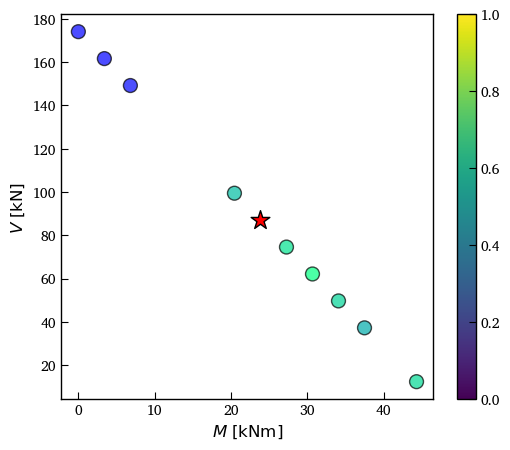

In [28]:
fig, ax = plt.subplots(figsize=(6,5))

plt.scatter(group_profiles['M'], group_profiles['V'],
            c=group_uncertainty, cmap='winter', s=100, edgecolor='black', alpha=0.7)

plt.scatter(new_profile['M'], new_profile['V'],
            c='red', s=200, edgecolor='black', label='New Profile', marker='*')

plt.xlabel(plot_params.feature_labels['M'])
plt.ylabel(plot_params.feature_labels['V'])

plt.colorbar()

plt.show()

### 3. Calculate Resistance with API

In [29]:
os.chdir(r"AL_API")
from API import IdeaConnectionClient

Absolute Paths are needed.

In [30]:
PATH = os.path.join(directory.root, "AL_API")
InputFileName = os.path.join(PATH,"Knee_widener_I_Output_red_Q4.parquet")

There are four idea templates. Depending on the existence of certain features, different templates have to be chosen. Depending on the lowest nonzero feature (see image), the according template is chosen.

<img src="templates.png" alt="image" width="600"/>

In [31]:
# All template names
ideatemplates_filenames = ['Corner.ideaCon',
                        'Corner_Stiffner.ideaCon',
                        'Corner_Stiff_Wid.ideaCon',
                        'Corner_Stiff2_Wid.ideaCon']

# Features that vary across templates
variable_features = ['t_stiffc',
                'h_wid',
                'b_wid',
                'd_wid',
                't_fwid',
                't_wwid',
                't_stiffb'
                ]

# How many variables each template has (e.g. Corner is the most simplest template and has 0 variable features)
existing_variable_features = {'Corner.ideaCon':0,
                              'Corner_Stiffner.ideaCon':1,
                              'Corner_Stiff_Wid.ideaCon':6,
                              'Corner_Stiff2_Wid.ideaCon':7}

existing_variable_features_indices = np.array(list(existing_variable_features.values()))

# Function to retrieve the ideal template based on the profile
def get_ideatemplate(profile):
    values = profile[variable_features].fillna(0).astype(float).values
    nonzero_indices = np.nonzero(values)[0]
    highest_nonzero_index = 0 if len(nonzero_indices) == 0 else np.max(nonzero_indices) + 1
    ideatemplate_id = np.nanargmin(np.abs(existing_variable_features_indices - highest_nonzero_index))
    return ideatemplates_filenames[ideatemplate_id]

Find the template for the considered profile and open it in IdeaStatica.

In [32]:
inputs = new_profile.copy()
ideatemplate = get_ideatemplate(inputs)
IdeaName = os.path.join(PATH,ideatemplate)

conn = IdeaConnectionClient()
conn.open(IdeaName)

c:\Users\benja\OneDrive\Desktop\Masterarbeit\Code\10_Neural_Networks\AL_API\Corner_Stiffner.ideaCon


### 4. Prepare

Adjust the feature labeling and the unit scaling to match with IdeaStatica.

In [33]:
i=inputs.index[0]  
params = {
    'Prof_c': inputs.at[i, 'Profile_x'], 'Prof_b': inputs.at[i, 'Profile_y'],
    'steel_grade': inputs.at[i, 'Steel grade_x'], 'gamma': inputs.at[i, 'Gamma'], 
    'h_wid': inputs.at[i, 'h_wid']/1000, 'b_wid': inputs.at[i, 'b_wid']/1000,
    'd_wid': inputs.at[i, 'd_wid']/1000, 't_fwid': inputs.at[i, 't_fwid']/1000,
    't_wwid': inputs.at[i, 't_wwid']/1000, 
    't_stiffc': inputs.at[i, 't_stiffc']/1000, 't_stiffb': inputs.at[i, 't_stiffb']/1000,
    'offset': inputs.at[i, 'Offset']/1000  
}

Load parameters into IdeaStatice to build the profile.

In [34]:
conn.update_params_by_name(params)
if not conn.params_valid():
    raise Exception("Parameters validation failed.")

#### 5. Define Loads

Functions to adjust loads incrementely up (underloaded) or down (overloaded).

In [35]:
def overloaded(calculated,profiles,i):
    k=0
    while calculated == False:
        print('k =', k)
        loads = conn.get_loads()
        if profiles.at[i,'M']==0:
            profiles.at[i,'V']*=0.9
        elif profiles.at[i,'V']==0:
            profiles.at[i,'M']*=0.9
        else:
            alpha = math.atan(profiles.at[i,'V']/profiles.at[i,'M'])
            r = (profiles.at[i,'M']**2+profiles.at[i,'V']**2)**0.5
            r*=0.9
            profiles.at[i,'M'] = r*math.cos(alpha)
            profiles.at[i,'V'] = r*math.sin(alpha)
        loads[0]['forcesOnSegments'][1]['my'] = int(profiles.at[i,'M']*1000)
        loads[0]['forcesOnSegments'][1]['qz'] = int(profiles.at[i,'V']*1000) #!!!!
        conn.set_loads(loads)
        print('M=',loads[0]['forcesOnSegments'][1]['my'] )
        print('V=',loads[0]['forcesOnSegments'][1]['qz'] ) 
        calculated = conn.calculate()
        k=(k+1)
        if k == 100:
            break
        
# In case of underload,, get in the loop and decrease the load:
def underloaded(applied_percentage,profiles,i):
    j=0
    while applied_percentage == 1:
        print('j =', j)
        print('Applied percentage =',applied_percentage)
        loads = conn.get_loads()
        if profiles.at[i,'M']==0:
            profiles.at[i,'V']*=1.1
        elif profiles.at[i,'V']==0:
            profiles.at[i,'M']*=1.1
        else:    
            alpha = math.atan(profiles.at[i,'V']/profiles.at[i,'M'])
            r = (profiles.at[i,'M']**2+profiles.at[i,'V']**2)**0.5
            r*=1.3
            profiles.at[i,'M'] = r*math.cos(alpha)
            profiles.at[i,'V'] = r*math.sin(alpha)
        loads[0]['forcesOnSegments'][1]['my'] = int(profiles.at[i,'M']*1000)
        loads[0]['forcesOnSegments'][1]['qz'] = int(profiles.at[i,'V']*1000) #!!!!
        conn.set_loads(loads)
        print('M=',loads[0]['forcesOnSegments'][1]['my'] )
        print('V=',loads[0]['forcesOnSegments'][1]['qz'] )    
        calculated = conn.calculate()
        if calculated == False:
            overloaded(calculated,profiles,i)
        
        # Get the applied loads:
        results = conn.get_results()
        loads = conn.get_loads()
        applied_percentage = results['analysis']['1']['appliedLoadPercentage']
        j=(j+1)

In [36]:
loads = conn.get_loads()

loads[0]['forcesOnSegments'][1]['my'] = int(inputs.at[i,'M']*1000)
loads[0]['forcesOnSegments'][1]['qz'] = int(inputs.at[i,'V']*1000)#!!!!

conn.set_loads(loads) 
print('M=',loads[0]['forcesOnSegments'][1]['my'] )
print('V=',loads[0]['forcesOnSegments'][1]['qz'] )            

M= 23839
V= 87076


In [37]:
new_profile['M'] = inputs['M'].values[0]
new_profile['V'] = inputs['V'].values[0]

### 6. Calculate

Calculate ...

In [38]:
calculated = conn.calculate()

if calculated == False:
    overloaded(calculated, new_profile, new_profile.index[0])

Get results:

In [39]:
results = conn.get_results()
loads = conn.get_loads()
applied_percentage = results['analysis']['1']['appliedLoadPercentage']   
if applied_percentage == 1:
    underloaded(applied_percentage,new_profile,new_profile.index[0])

applied_M = applied_percentage * loads[0]['forcesOnSegments'][1]['my']
applied_V = applied_percentage * loads[0]['forcesOnSegments'][1]['qz']

outputs = inputs.copy()

outputs.at[i, 'proz'] = applied_percentage
outputs.at[i, 'M_Rd'] = applied_M/1000 # [kNm]
outputs.at[i, 'V_Rd'] = applied_V/1000 # [kN]

cost = results['costEstimationResults']['totalEstimatedCost']
outputs.at[i, 'cost'] = cost

Final profile with calculate moment and shear resistance.

In [40]:
outputs

,Profile_x,h_x,b_x,tw_x,tf_x,A_x,Av_x,Iy_x,Wely_x,Wply_x,...,M_Rd,V_Rd,V_contribution,M_contribution,V_norm,M_norm,target,Cat_h,Cat_t_stiffc,cost
714385,HEA140,133,140,5.5,8.5,3141.610658,1012.360658,10330000,155400.0,173500,...,22.721547,82.994313,0.690079,0.723734,0.049662,0.678079,0.679895,0,1,125.573642


Calculate the target value from the resulting moment and shear resistance.

In [41]:
def calculate_target_from_Rd(profile):
    profile['V_norm'] = abs(profile['V_Rd'] / profile['Vpl_y'])
    profile['M_norm'] = abs(profile['M_Rd'] / profile['Mpl_y'])
    profile['target'] = (profile['V_norm']**2 + profile['M_norm']**2)**0.5

In [42]:
calculate_target_from_Rd(outputs)

In [43]:
conn.close()

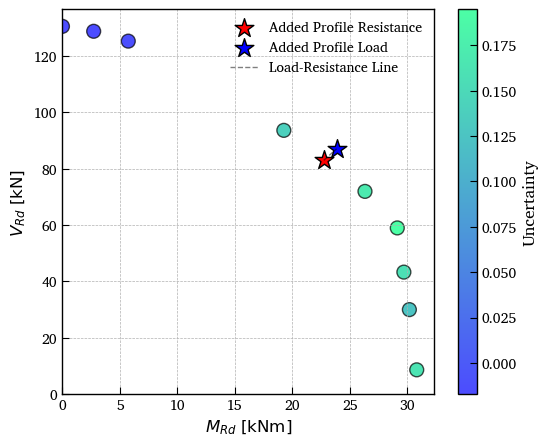

In [44]:
fig, ax = plt.subplots(figsize=(6,5))

sc = plt.scatter(df_full.loc[most_uncertain_group_ids]['M_Rd'].values,
            df_full.loc[most_uncertain_group_ids]['V_Rd'].values,
            c=group_uncertainty, cmap='winter', s=100, edgecolor='black', alpha=0.7)

plt.scatter(outputs['M_Rd'].values,
            outputs['V_Rd'].values,
            c='red', s=200, edgecolor='black', label='Added Profile Resistance', marker='*')

plt.scatter(outputs['M'],
            outputs['V'],
            c='blue', s=200, edgecolor='black', label='Added Profile Load', marker='*')

plt.plot((outputs['M_Rd'].values, outputs['M'].values),(outputs['V_Rd'].values, outputs['V'].values),
         color='black', linestyle='--', linewidth=1, alpha=0.5, label='Load-Resistance Line')

plt.xlabel(plot_params.feature_labels['M_Rd'])
plt.ylabel(plot_params.feature_labels['V_Rd'])

plt.legend()
plt.colorbar(sc,label='Uncertainty')
plt.xlim(0, None)
plt.ylim(0, None)
plt.grid(True, which='both', linestyle='--', linewidth=0.5)

plt.show()

## Local Active Learning

In [340]:
model_AL = copy.deepcopy(model)
df_AL = df_full.copy()

### Define Learning Parameters

In [341]:
iterations = 1
groups_per_iter = 20
add_per_group = 2

finetuning_lr = model.config['learning_rate']
patience = 3

print(f"Added Samples per iteration: {groups_per_iter * add_per_group}")
print(f"Added Samples: {iterations * groups_per_iter * add_per_group}")

Added Samples per iteration: 40
Added Samples: 40


In [342]:
epoch_per_data_ratio = model_AL.config['epochs'] / len(model_AL.data['data_indeces'])
print(f"Epochs per data ratio: {epoch_per_data_ratio}")

Epochs per data ratio: 0.004199416281136922


In [343]:
epochs_per_iter = max(int(epoch_per_data_ratio * groups_per_iter * add_per_group) * 10, 5)
print(f"Epochs per iteration: {epochs_per_iter}")
print(f"Total Epochs: {iterations * epochs_per_iter}")

Epochs per iteration: 5
Total Epochs: 5


### Define Save Options

In [344]:
save_interim_results = False

In [345]:
model_name = "DNN_Model_AL_Finetuned"
database_filename = "Extended_Database.csv"

MODEL_SAVE_PATH = os.path.join(directory.root, "Saved Models", model_name)
directory.create_folder(MODEL_SAVE_PATH)
MODEL_SAVE_FILE = os.path.join(MODEL_SAVE_PATH, f"{model_name}.pth")

DATA_SAVE_FILE = os.path.join(directory.root, "Data", database_filename)

In [346]:
#identical_groups = df_AL[fixed_features].groupby(list(df_AL[fixed_features].columns)).apply(lambda x: x.index.tolist()).tolist()
# Initialize a Series to store group IDs
df_AL['group_id'] = df_AL[fixed_features].groupby(fixed_features).ngroup()
identical_groups = df_AL.groupby('group_id').apply(lambda x: x.index.tolist()).tolist()

### Data Generation

#### Active Learning Loop

In [300]:
import time

In [347]:
for iter in range(iterations):
    print(f"*** Iteration {iter+1}/{iterations} ***")
    current_id = len(df_AL)
    # Get the most uncertain samples
    print('Get Uncertainties')
    
    #mcd_mean, mcd_std, _ = model_AL.mc_dropout_uncertainty(df_AL, num_samples=100)
    #uncertainty = mcd_std / mcd_mean

    y_preds, _ = model_AL.predict(df_AL)
    y_preds = y_preds.numpy().flatten()
    y_truth = df_AL['target'].values
    rel_error = np.abs((y_preds - y_truth) / y_truth+1e-8)
    uncertainty = rel_error

    uncertainty_per_group = np.array([uncertainty[group].max() for group in identical_groups])
    most_uncertain_groups = np.argsort(uncertainty_per_group)[-groups_per_iter:]

    df_new_profiles = pd.DataFrame(columns=df_AL.columns)

    for i, group_id in enumerate(most_uncertain_groups):
        print(f"   Processing Group {i/len(most_uncertain_groups):.2%} (Group id: {group_id})")

        group = np.array(identical_groups[group_id])
        df_group = df_AL.loc[group].copy()
        
        base_id = identical_groups[group_id][0]
        identical_groups[group_id].extend(np.arange(current_id, current_id + add_per_group))

        base_profile = df_AL.iloc[base_id:base_id+1].copy()
        base_profile['M_Rd'] = None
        base_profile['V_Rd'] = None
        base_profile['M'] = None
        base_profile['V'] = None
        base_profile['proz'] = None
        base_profile['base_sample_id'] = int(base_id)
        base_profile['iteration'] = int(iter+1)
        base_profile['group_id'] = int(group_id)

        ideatemplate = get_ideatemplate(base_profile.iloc[0])
        base_profile['template'] = ideatemplate

        new_profiles = pd.concat([base_profile]*add_per_group, ignore_index=True)
        new_profiles.index = current_id + np.arange(add_per_group)

        group_uncertainty = uncertainty[group]
        group_uncertainty_extended = group_uncertainty.copy()
        V_contributions = df_group['V_contribution'].values

        for j in list(new_profiles.index):
            ratio = find_optimal_location(V_contributions, group_uncertainty_extended) 
            M_contribution, V_contribution = get_MV_contribution(ratio)

            new_profiles.at[j, 'M_contribution'] = round(M_contribution, 6)
            new_profiles.at[j, 'V_contribution'] = round(V_contribution, 6)

            #print(f"      Add Load M_cont:{M_contribution:.2f}, V_cont: {V_contribution:2f}")

            V_contributions = np.append(V_contributions, V_contribution)
            group_uncertainty_extended = np.append(group_uncertainty_extended, max(group_uncertainty))

            current_id += 1

        # Define the loads:
        get_MV(new_profiles)

        df_new_profiles = pd.concat([df_new_profiles, new_profiles], ignore_index=False)

    unique_templates = df_new_profiles['template'].unique()
    print(f"Unique templates in this iteration: {unique_templates}")

    for ideatemplate in unique_templates:
        print('   Open Idea for template:', ideatemplate)
        # Calculation of the new Profiles
        IdeaName = os.path.join(PATH,ideatemplate)

        conn = IdeaConnectionClient()
        conn.open(IdeaName)

        new_profiles_template = df_new_profiles[df_new_profiles['template'] == ideatemplate]

        for j,profile_id in enumerate(list(new_profiles_template.index)):
            print(f"      Processing Profile {(j+1)/len(new_profiles_template):.2%} (Profile id {profile_id}, Base id: {new_profiles_template.at[profile_id, 'base_sample_id']})")

            params = {
                'Prof_c': new_profiles_template.at[profile_id, 'Profile_x'], 'Prof_b': new_profiles_template.at[profile_id, 'Profile_y'],
                'steel_grade': new_profiles_template.at[profile_id, 'Steel grade_x'], 'gamma': new_profiles_template.at[profile_id, 'Gamma'],
                'h_wid': new_profiles_template.at[profile_id, 'h_wid']/1000, 'b_wid': new_profiles_template.at[profile_id, 'b_wid']/1000,
                'd_wid': new_profiles_template.at[profile_id, 'd_wid']/1000, 't_fwid': new_profiles_template.at[profile_id, 't_fwid']/1000,
                't_wwid': new_profiles_template.at[profile_id, 't_wwid']/1000,
                't_stiffc': new_profiles_template.at[profile_id, 't_stiffc']/1000, 't_stiffb': new_profiles_template.at[profile_id, 't_stiffb']/1000,
                'offset': new_profiles_template.at[profile_id, 'Offset']/1000
            }

            #print('         Set Load in Idea')
            conn.update_params_by_name(params)
            if not conn.params_valid():
                raise Exception("Parameters validation failed.")
            
            loads = conn.get_loads()

            loads[0]['forcesOnSegments'][1]['my'] = int(new_profiles_template.at[profile_id,'M']*1000)
            loads[0]['forcesOnSegments'][1]['qz'] = int(new_profiles_template.at[profile_id,'V']*1000)#!!!!

            conn.set_loads(loads) 
            #print('         M=',loads[0]['forcesOnSegments'][1]['my'] )
            #print('         V=',loads[0]['forcesOnSegments'][1]['qz'] )           

            print('         Calculate...') 
            start_time = time.time()
            calculated = conn.calculate()
            if calculated == False:
                overloaded(calculated,new_profiles_template,profile_id)
            end_time = time.time()

            df_new_profiles.at[profile_id, 'calculation_time'] = end_time - start_time

            results = conn.get_results()
            loads = conn.get_loads()
            applied_percentage = results['analysis']['1']['appliedLoadPercentage']   
            if applied_percentage == 1:
                underloaded(applied_percentage,new_profiles_template,profile_id)

            applied_M = applied_percentage * loads[0]['forcesOnSegments'][1]['my']
            applied_V = applied_percentage * loads[0]['forcesOnSegments'][1]['qz']

            df_new_profiles.at[profile_id, 'proz'] = applied_percentage
            df_new_profiles.at[profile_id, 'M_Rd'] = applied_M/1000 # [kNm]
            df_new_profiles.at[profile_id, 'V_Rd'] = applied_V/1000 # [kN]

            cost = results['costEstimationResults']['totalEstimatedCost']
            df_new_profiles.at[profile_id, 'cost'] = cost

            calculate_target_from_Rd(df_new_profiles)

        print('   Close Idea')
        conn.close()

    # Save the new profiles
    if save_interim_results:
        df_new_profiles.to_csv(os.path.join(directory.root, "Data", f"extended_profiles_iter_{iter+1}.csv"), index=True)

    # Fine Tune the model
    print('Fine Tune the model')
    model_AL.fine_tune(df_new_profiles,epochs=epochs_per_iter)
    df_AL = pd.concat([df_AL, df_new_profiles], ignore_index=False)

*** Iteration 1/1 ***
Get Uncertainties
   Processing Group 0.00% (Group id: 5867)
   Processing Group 5.00% (Group id: 12183)
   Processing Group 10.00% (Group id: 8884)
   Processing Group 15.00% (Group id: 1373)
   Processing Group 20.00% (Group id: 1616)
   Processing Group 25.00% (Group id: 6113)
   Processing Group 30.00% (Group id: 2783)
   Processing Group 35.00% (Group id: 2540)
   Processing Group 40.00% (Group id: 1853)
   Processing Group 45.00% (Group id: 3961)
   Processing Group 50.00% (Group id: 10138)
   Processing Group 55.00% (Group id: 1617)
   Processing Group 60.00% (Group id: 6787)
   Processing Group 65.00% (Group id: 4912)
   Processing Group 70.00% (Group id: 3247)
   Processing Group 75.00% (Group id: 13384)
   Processing Group 80.00% (Group id: 3486)
   Processing Group 85.00% (Group id: 14732)
   Processing Group 90.00% (Group id: 7744)
   Processing Group 95.00% (Group id: 10804)
Unique templates in this iteration: ['Corner_Stiffner.ideaCon' 'Corner_Stiff_

#### Save Dataframe

In [ ]:
df_AL.to_csv(DATA_SAVE_FILE, index=True)
model_AL = DNN()
model_AL.load(MODEL_SAVE_FILE)

#### Save Model

In [ ]:
model_AL.save(MODEL_SAVE_FILE)

Root Directory set to:  c:\Users\benja\OneDrive\Desktop\Masterarbeit\Code\10_Neural_Networks
Model saved to: Saved Models\DNN_Model_AL_Finetuned\DNN_Model_AL_Finetuned.pth


### Load Dataframe & finetuned Model (given existing files)

In [48]:
df_AL = pd.read_csv(DATA_SAVE_FILE)
model_AL = torch.load(MODEL_SAVE_FILE)
identical_groups = df_AL.groupby('group_id').apply(lambda x: x.index.tolist()).tolist()

## Analysis of Results

### Model Performance

In [354]:
ids_added = np.array(list(df_AL.loc[len(df):].index))
ids_before = np.array(list(df_full.index))
df_added = df_AL.loc[ids_added].copy()

# Get Predictions before AL
y_preds_before, _ = model.predict(df_AL)
y_truth_before = df_AL['target'].values

# Get Predictions after AL
y_preds_after, _ = model_AL.predict(df_AL)
y_truth_after = df_AL['target'].values

y_preds_after = y_preds_after.numpy().flatten()
y_preds_before = y_preds_before.numpy().flatten()

# Calculate relative error
error_before = np.abs((y_preds_before - y_truth_before) / y_truth_before+1e-8)
error_after = np.abs((y_preds_after[ids_before] - y_truth_after[ids_before]) / y_truth_after[ids_before]+1e-8)
error_added = np.abs((y_preds_after[ids_added] - y_truth_after[ids_added]) / y_truth_after[ids_added]+1e-8)

In [60]:
metrics_before = model.get_metrics()
metrics_after = model_AL.get_metrics()

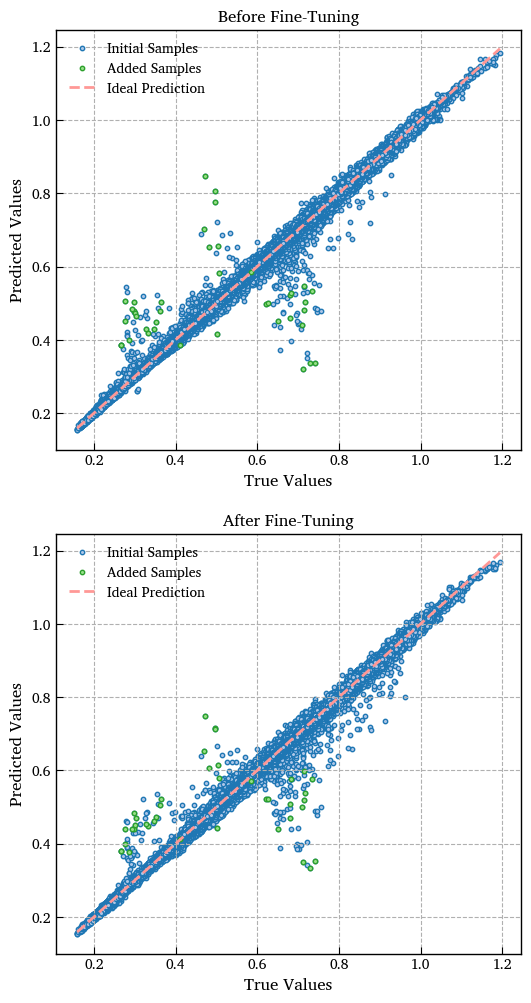

In [ ]:
fig, axs = plt.subplots(2,1,figsize=(6, 12))

axs[0].scatter(y_truth_before, y_preds_before,
               label='Initial Samples',
            #label=rf'$R^2$ = {metrics_before["R2"]:.3f}', 
            facecolor=plot_params.morecolors[1],
            edgecolor=plot_params.morecolors[0],
            s=10,
            zorder=2
            )

axs[0].scatter(y_truth_before[ids_added], y_preds_before[ids_added],
               label='Added Samples',
            facecolor=plot_params.morecolors[5],
            edgecolor=plot_params.morecolors[4],
            s=10,
            zorder=2
            )

axs[0].plot([y_truth_before.min(), y_truth_before.max()],
            [y_truth_before.min(), y_truth_before.max()], 
            color=plot_params.morecolors[6], linestyle='--', linewidth=2, label='Ideal Prediction',
            zorder=3)

axs[0].grid(True, linestyle='--', zorder=0)

axs[1].scatter(y_truth_after, y_preds_after, 
               label='Initial Samples',
            #label=rf'$R^2$ = {metrics_after["R2"]:.3f}', 
            facecolor=plot_params.morecolors[1],
            edgecolor=plot_params.morecolors[0],
            s=10
            )

axs[1].scatter(y_truth_after[ids_added], y_preds_after[ids_added],
            label='Added Samples', 
            facecolor=plot_params.morecolors[5],
            edgecolor=plot_params.morecolors[4],
            s=10
            )

axs[1].plot([y_truth_before.min(), y_truth_before.max()],
            [y_truth_before.min(), y_truth_before.max()], 
            color=plot_params.morecolors[6], linestyle='--', linewidth=2, label='Ideal Prediction',
            zorder=3)

axs[1].grid(True, linestyle='--', zorder=0)

axs[0].legend()
axs[1].legend()

axs[0].set_title('Before Fine-Tuning')
axs[1].set_title('After Fine-Tuning')

axs[0].set_xlabel('True Values')
axs[1].set_xlabel('True Values')

axs[0].set_ylabel('Predicted Values')
axs[1].set_ylabel('Predicted Values')

plt.show()

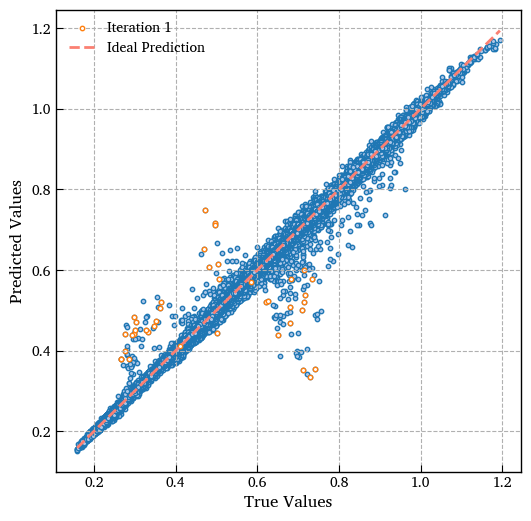

In [352]:
fig, ax = plt.subplots(figsize=(6, 6))

ax.scatter(y_truth_after, y_preds_after, 
            #label=rf'$R^2$ = {metrics_after["R2"]:.3f}', 
            facecolor=plot_params.morecolors[1],
            edgecolor=plot_params.morecolors[0],
            s=10,
            alpha=1.0
            )

for i in range(iterations):
    ax.scatter(y_truth_after[df_AL['iteration'] == i+1],
                y_preds_after[df_AL['iteration'] == i+1],
                label=f'Iteration {i+1}',
                facecolor='white',
                edgecolor=plot_params.morecolors[2*(i+1)],
                s=10,
                alpha=1.0
                )

ax.plot([y_truth_before.min(), y_truth_before.max()],
            [y_truth_before.min(), y_truth_before.max()], 
            color=plot_params.colors[3], linestyle='--', linewidth=2, label='Ideal Prediction')

ax.grid(True, linestyle='--', zorder=0)
ax.legend()
ax.set_xlabel('True Values')
ax.set_ylabel('Predicted Values')

plt.show()

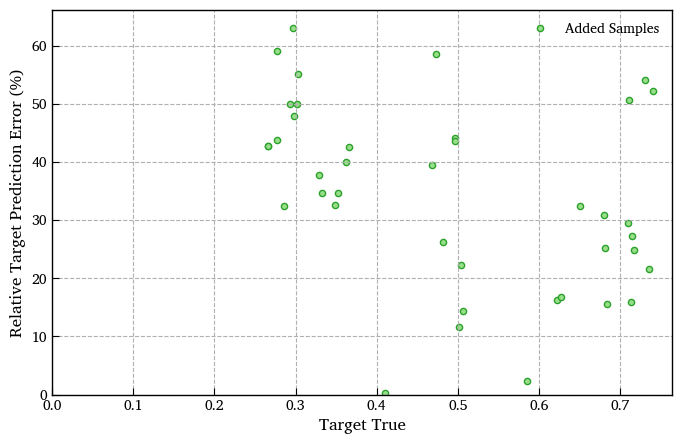

In [359]:
fig, ax = plt.subplots(figsize=(8, 5))

plt.scatter(df_added['target'],error_added*100,
            label='Added Samples',
            facecolor=plot_params.morecolors[5],
            edgecolor=plot_params.morecolors[4],
            s=20
            )

plt.xlabel('Target True')
plt.ylabel('Relative Target Prediction Error (%)')
plt.legend()

plt.ylim(0, None)
plt.xlim(0, None)
plt.grid(True, linestyle='--', zorder=0)

plt.show()

In [46]:
worst_samples = np.argsort(error_added)[-10:]

df_added.iloc[worst_samples].sort_values(by='target', ascending=False)

,Profile_x,h_x,b_x,tw_x,tf_x,A_x,Av_x,Iy_x,Wely_x,Wply_x,...,V_norm,M_norm,target,Cat_h,Cat_t_stiffc,cost,Unnamed: 0,base_sample_id,iteration,template
720381,HEA400,390,300,11.0,19.0,15897.778956,5732.778956,450700000,2311000.0,2562000,...,0.013098,0.018529,0.022691,0,1,31.483132,720381.0,161754.0,2.0,Corner.ideaCon
720379,HEA400,390,300,11.0,19.0,15897.778956,5732.778956,450700000,2311000.0,2562000,...,0.015414,0.016334,0.022458,0,1,31.483132,720379.0,161754.0,2.0,Corner.ideaCon
720351,HEA200,190,200,6.5,10.0,5383.123980,1808.123980,36920000,388600.0,429500,...,0.012158,0.018857,0.022436,0,1,6.851456,720351.0,153057.0,2.0,Corner.ideaCon
717762,HEA220,210,220,7.0,11.0,6434.123980,2067.123980,54100000,515200.0,568500,...,0.012079,0.018354,0.021973,1,1,9.087990,717762.0,246960.0,2.0,Corner.ideaCon
720384,HEA500,490,300,12.0,23.0,19753.778956,7471.778956,869700000,3550000.0,3949000,...,0.010104,0.015192,0.018245,1,1,43.829408,720384.0,401774.0,2.0,Corner.ideaCon
720375,HEA400,390,300,11.0,19.0,15897.778956,5732.778956,450700000,2311000.0,2562000,...,0.010478,0.014823,0.018153,0,1,31.483132,720375.0,162325.0,2.0,Corner.ideaCon
717729,HEA450,440,300,11.5,21.0,17802.778956,6578.278956,637200000,2896000.0,3216000,...,0.010273,0.014904,0.018101,0,1,38.110780,717729.0,163392.0,2.0,Corner.ideaCon
714695,HEA500,490,300,12.0,23.0,19753.778956,7471.778956,869700000,3550000.0,3949000,...,0.011890,0.013392,0.017909,1,1,43.829408,714695.0,401774.0,1.0,Corner.ideaCon
720382,HEA500,490,300,12.0,23.0,19753.778956,7471.778956,869700000,3550000.0,3949000,...,0.011890,0.013392,0.017909,1,1,43.829408,720382.0,401774.0,2.0,Corner.ideaCon
717727,HEA450,440,300,11.5,21.0,17802.778956,6578.278956,637200000,2896000.0,3216000,...,0.012089,0.013138,0.017854,0,1,38.110780,717727.0,163392.0,2.0,Corner.ideaCon


### Loss Progression

Training and Validation Loss Spike

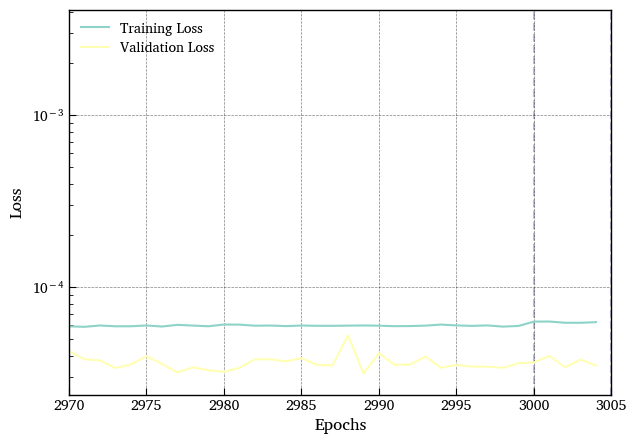

In [360]:
fig, ax = plt.subplots(figsize=(7,5))

plt.plot(model_AL.train_losses['total'], label='Training Loss', c=plot_params.colors[0],zorder=2)
plt.plot(model_AL.val_losses['total'], label='Validation Loss', c=plot_params.colors[1],zorder=2)

for i in range(iterations):
    iterations_start = model_AL.config['epochs'] + i * epochs_per_iter
    iterations_end = iterations_start + epochs_per_iter
    plt.axvline(x=iterations_start, color=plot_params.colors[2], linestyle='--',zorder=0)
    plt.axvline(x=iterations_end, color=plot_params.colors[2], linestyle='--',zorder=0)

plt.xlabel('Epochs')
plt.ylabel('Loss')

plt.yscale('log')

plt.grid(True, which='major', color='k', linestyle='--', linewidth=0.5, alpha=0.5)
plt.xlim([0.99*model.config['epochs'],model.config['epochs']+iterations*epochs_per_iter])
plt.yscale('log')
plt.legend()

### Features of Data Added

In [69]:
df_added = df_AL.loc[ids_added].copy()

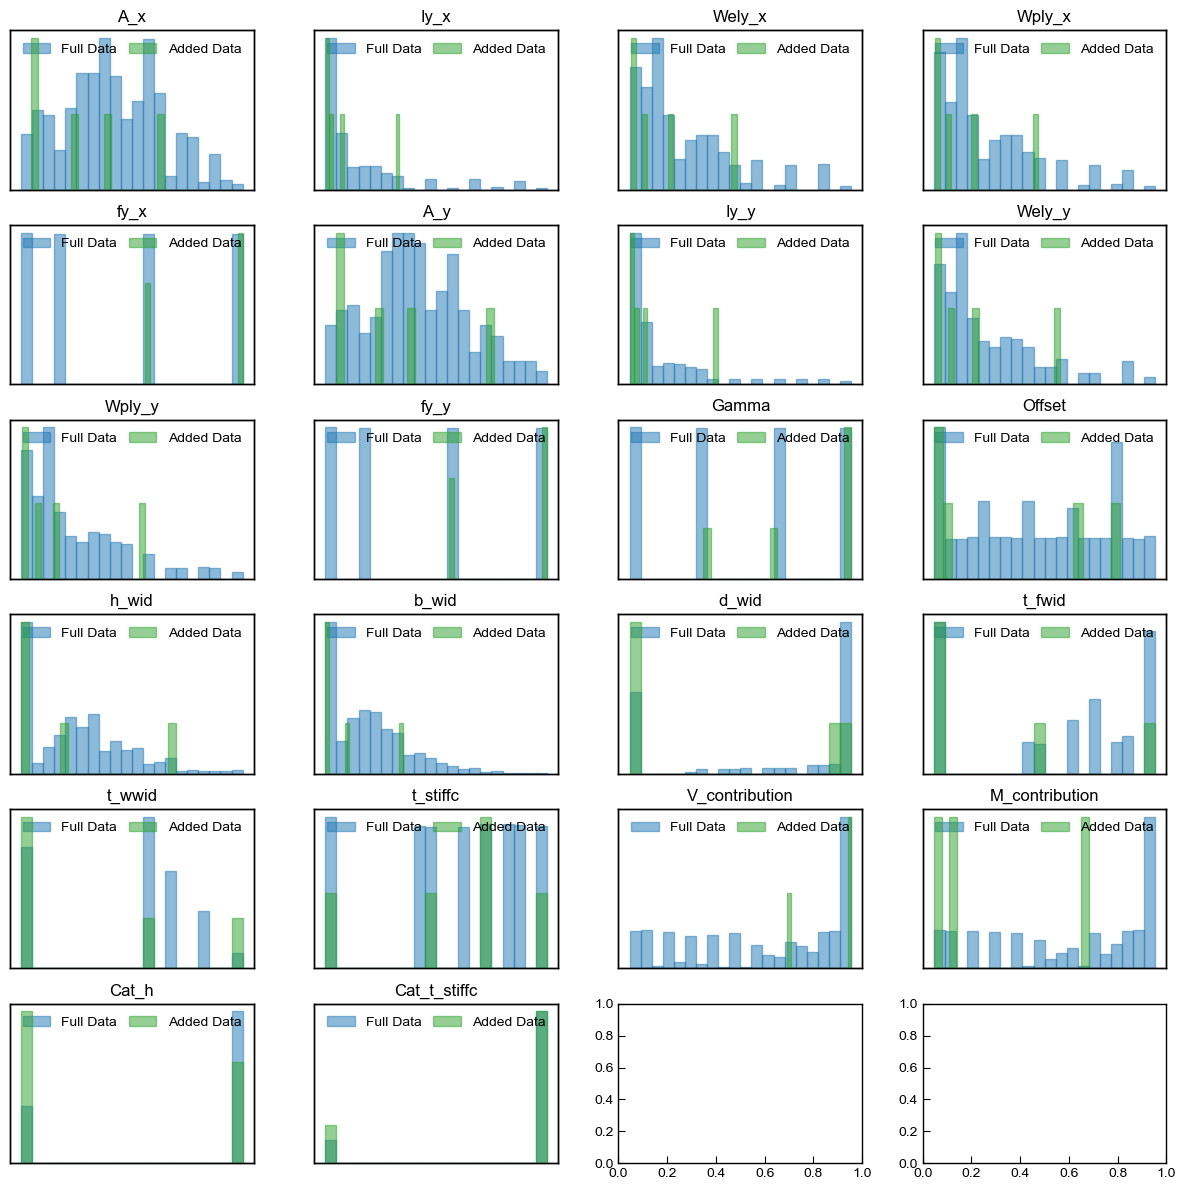

In [182]:
fig, axs = plt.subplots(int(len(model.features)/4)+1, 4, figsize=(12, 12), sharey=False)

for i, feature in enumerate(model.features):
    ax = axs[int(i/4), i%4]
    ax2 = ax.twinx()

    ax.hist(df_full[feature].values, bins=20, 
            edgecolor=plot_params.colors[0], 
            facecolor=plot_params.colors[0],
            alpha=0.5, label='Full Data')
    ax2.hist(df_added[feature].values, bins=20, 
             edgecolor=plot_params.colors[2],
             facecolor=plot_params.colors[2],
             alpha=0.5, label='Added Data')

    ax.set_title(feature)
    ax.set_xticks([])
    ax.set_yticks([])
    ax2.set_yticks([])
    ax.legend(loc='upper left')
    ax2.legend(loc='upper right')

plt.tight_layout()
plt.show()

### Check added M-V location

In [389]:
def calculate_error(curve, points):
    curve = np.asarray(curve, dtype=float)
    points = np.atleast_2d(np.asarray(points, dtype=float))

    diff = np.diff(curve, axis=0)
    lengths = np.sqrt((diff ** 2).sum(axis=1))
    unit_vectors = diff / lengths[:, np.newaxis]

    points = np.atleast_2d(points)
    # Extracts the starting point of each segment — these are the anchors for the line segments.
    start_points = curve[:-1]

    start_to_points = points[:, np.newaxis, :] - start_points
    # Scalar projection
    projections = np.einsum('ijk,jk->ij', start_to_points, unit_vectors)
    projections = np.clip(projections, 0, lengths)

    closest_points = start_points + unit_vectors * projections[..., np.newaxis]
    distances = np.sqrt(((closest_points - points[:, np.newaxis, :]) ** 2).sum(axis=2))
    
    min_distances = distances.min(axis=1)
    closest_indices = distances.argmin(axis=1)

    return min_distances, closest_indices

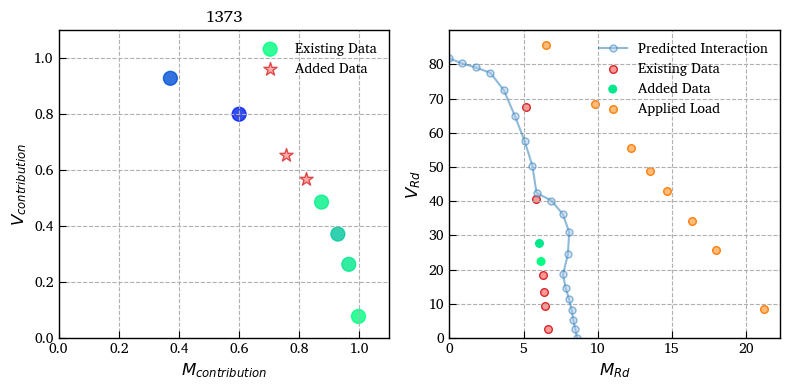

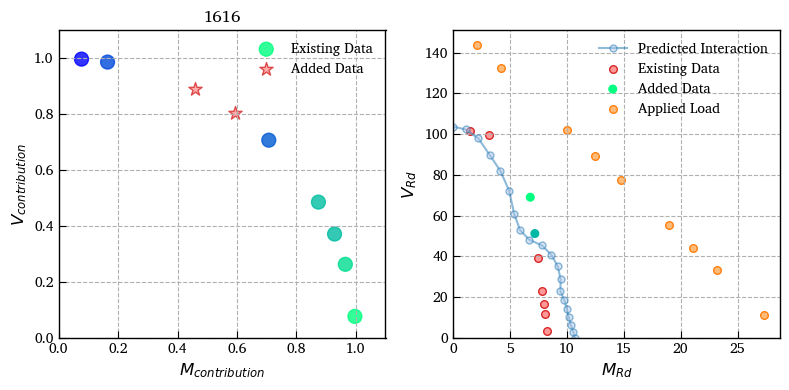

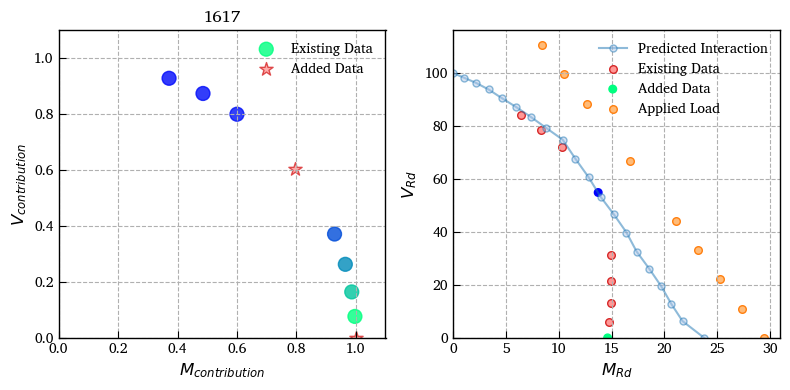

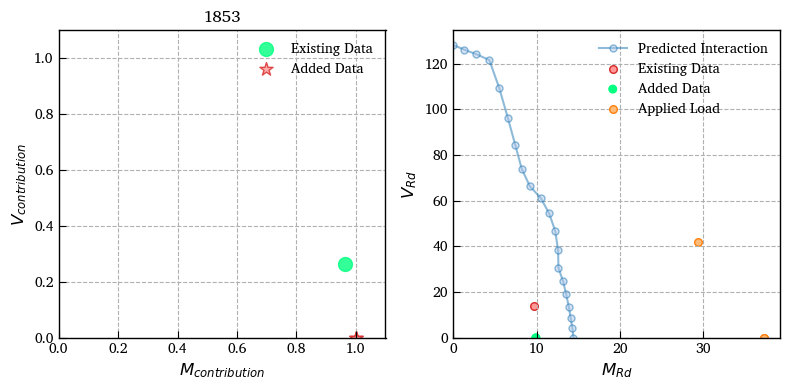

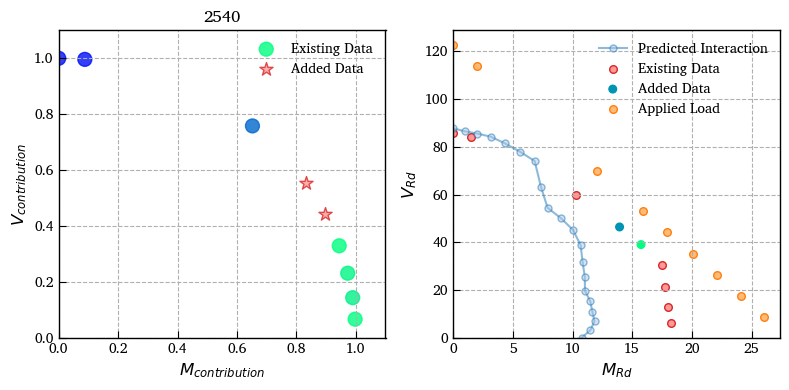

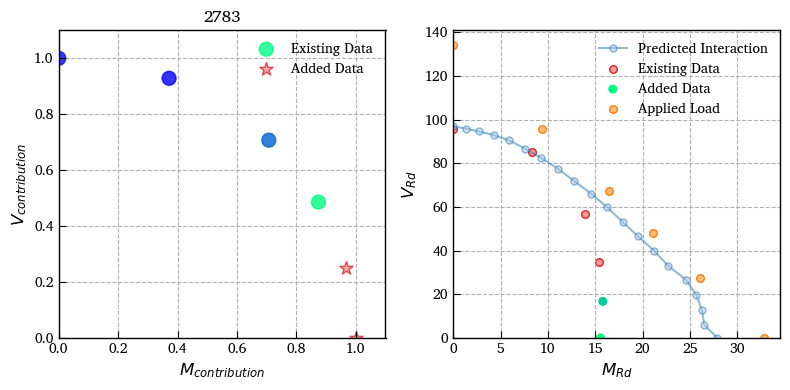

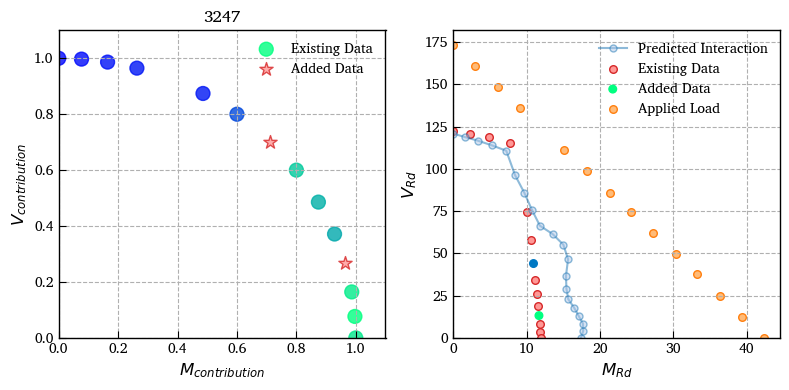

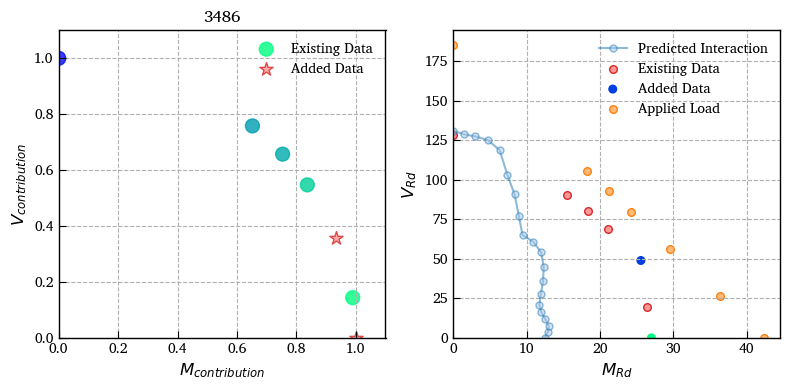

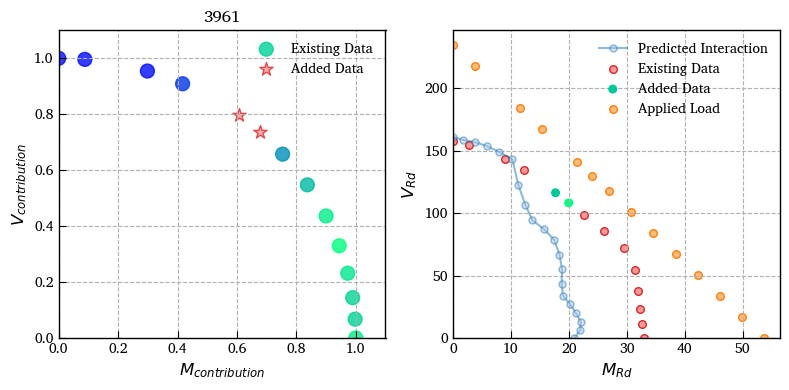

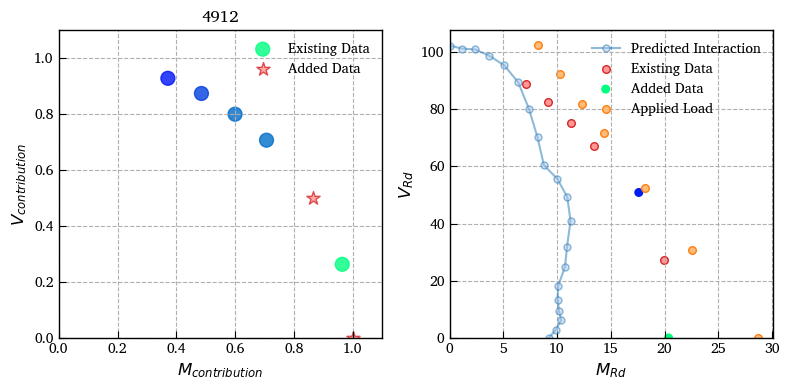

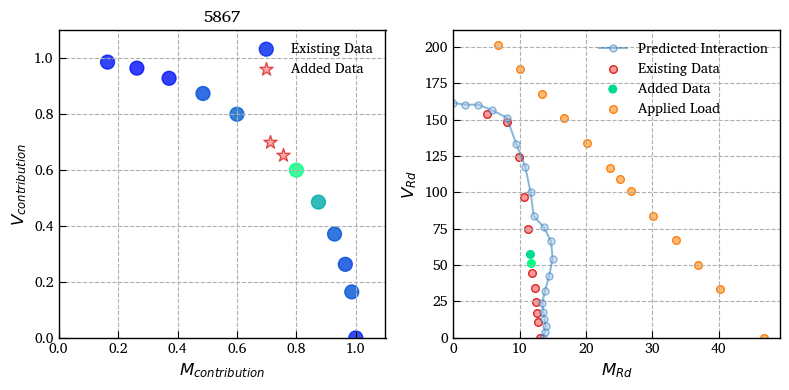

In [392]:
n_before = len(df_full)
counter = 0
for group_id,group in enumerate(identical_groups):
    if max(group) > n_before:
        if max(group) > len(df_AL):
            print(group)
            continue
        if counter > 10:
            break
        else:
            counter += 1

        M_contribution = df_AL.loc[group]['M_contribution'].values
        V_contribution = df_AL.loc[group]['V_contribution'].values
        
        mask_before = np.where(np.array(group) < n_before)[0]
        mask_added = np.where(np.array(group) >= n_before)[0]

        base_profile = df_AL.loc[group[0]].copy()
        df_group = df_AL.loc[group].copy()
        M_Rd_pred, V_Rd_pred, targets_predicted = model.get_MV_interaction_prediction(base_profile,n_predictions=20)

        interaction_curve = np.array([M_Rd_pred, V_Rd_pred]).T
        added_resistances = np.array([df_group['M_Rd'].values[mask_added], df_group['V_Rd'].values[mask_added]]).T
        errors, closest_points = calculate_error(
            interaction_curve,
            added_resistances
        )

        vector_lengths = np.linalg.norm(interaction_curve[closest_points], axis=1)

        rel_deviation = errors / vector_lengths

        fig, axs = plt.subplots(1,2,figsize=(8, 4))
        ax = axs[0]
        ax.scatter(M_contribution[mask_before], V_contribution[mask_before],
                    label='Existing Data',
                    c=np.abs(rel_error[np.array(group)[mask_before]]),
                    cmap='winter',
                    vmin=0,
                    alpha=0.8,
                    s=100)
        ax.scatter(M_contribution[mask_added], V_contribution[mask_added],
                    label='Added Data',
                    marker='*',
                    facecolor=plot_params.morecolors[7],
                    edgecolor=plot_params.morecolors[6],
                    alpha=0.8,
                    s=100)
        ax.set_xlabel(r'$M_{contribution}$')
        ax.set_ylabel(r'$V_{contribution}$')
        ax.grid(True, linestyle='--', zorder=0)
        ax.set_title(group_id)
        ax.set_xlim(0, 1.1)
        ax.set_ylim(0, 1.1)
        ax.legend()

        ax = axs[1]
        ax.plot(M_Rd_pred, V_Rd_pred, 
                    label='Predicted Interaction',
                    marker='o',
                    c=plot_params.morecolors[0],
                    markerfacecolor=plot_params.morecolors[1],
                    markeredgecolor=plot_params.morecolors[0],
                    alpha=0.5,
                    markersize=5)

        ax.scatter(df_group['M_Rd'].values[mask_before], df_group['V_Rd'].values[mask_before],
                    label='Existing Data',
                    facecolor=plot_params.morecolors[7],
                    edgecolor=plot_params.morecolors[6],
                    alpha=1.0,
                    s=30)
        ax.scatter(df_group['M_Rd'].values[mask_added], df_group['V_Rd'].values[mask_added],
                    label='Added Data',
                    c=rel_deviation,
                    cmap='winter',
                    vmin=0,
                    alpha=1.0,
                    s=30)
        ax.scatter(df_group['M'].values, df_group['V'].values,
                    label='Applied Load',
                    facecolor=plot_params.morecolors[3],
                    edgecolor=plot_params.morecolors[2],
                    s=30)

        ax.set_xlabel(r'$M_{Rd}$')
        ax.set_ylabel(r'$V_{Rd}$')
        ax.set_xlim(0, None)
        ax.set_ylim(0, None)
        ax.grid(True, linestyle='--', zorder=0)
        ax.legend()

        plt.tight_layout()
        plt.show()

### Analyse Errors

In [393]:
n_before = len(df_full)
for group_id,group in enumerate(identical_groups):
    if max(group) > n_before:
        mask_before = np.where(np.array(group) < n_before)[0]
        mask_added = np.where(np.array(group) >= n_before)[0]

        base_profile = df_AL.loc[group[0]].copy()
        df_group = df_AL.loc[group].copy()
        M_Rd_pred, V_Rd_pred, targets_predicted = model.get_MV_interaction_prediction(base_profile,n_predictions=20)

        interaction_curve = np.array([M_Rd_pred, V_Rd_pred]).T
        added_resistances = np.array([df_group['M_Rd'].values[mask_added], df_group['V_Rd'].values[mask_added]]).T
        errors, closest_points = calculate_error(
            interaction_curve,
            added_resistances
        )

        vector_lengths = np.linalg.norm(interaction_curve[closest_points], axis=1)

        rel_deviation = errors / vector_lengths
        df_AL.loc[np.array(group)[mask_added], 'rel_deviation'] = rel_deviation

In [394]:
df_error = df_AL[~np.isnan(df_AL['rel_deviation'])].copy()

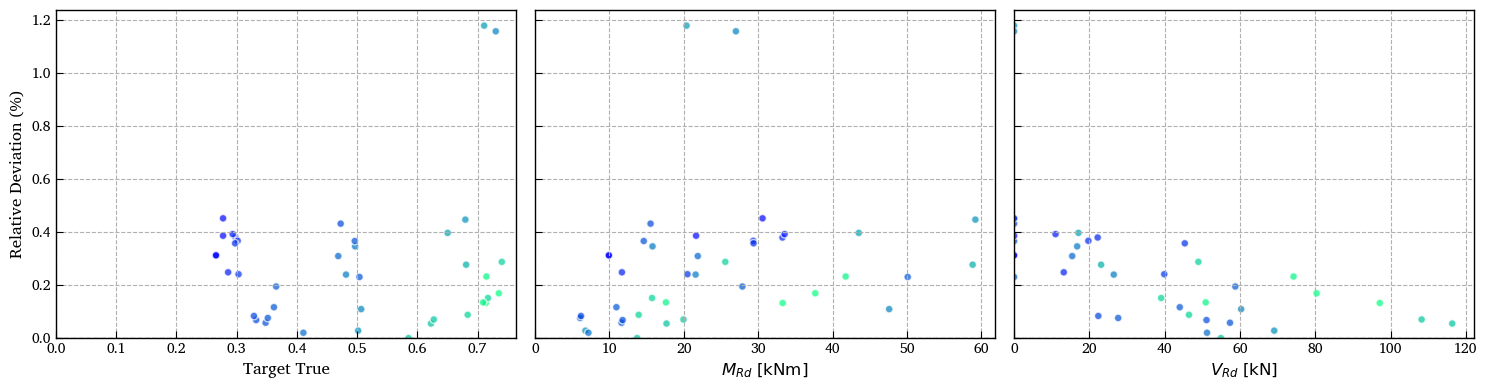

In [395]:
fig, axs = plt.subplots(1, 3, figsize=(15, 4),sharey=True)
axs[0].scatter(df_error['target'], df_error['rel_deviation'],
               c=df_error['proz'], cmap='winter', s=30, edgecolor='white', alpha=0.7)
axs[0].set_xlabel('Target True')
axs[0].set_ylabel('Relative Deviation (%)')

axs[1].scatter(df_error['M_Rd'], df_error['rel_deviation'],
               c=df_error['proz'], cmap='winter', s=30, edgecolor='white', alpha=0.7)
axs[1].set_xlabel(plot_params.feature_labels['M_Rd'])

axs[2].scatter(df_error['V_Rd'], df_error['rel_deviation'],
               c=df_error['proz'], cmap='winter', s=30, edgecolor='white', alpha=0.7)
axs[2].set_xlabel(plot_params.feature_labels['V_Rd'])

for ax in axs:
    ax.axhline(y=0, color='black', linestyle='--', linewidth=1, alpha=0.5)
    ax.set_ylim(0, None)
    ax.set_xlim(0, None)
    ax.grid(True, linestyle='--', zorder=0)

plt.tight_layout()
plt.show()

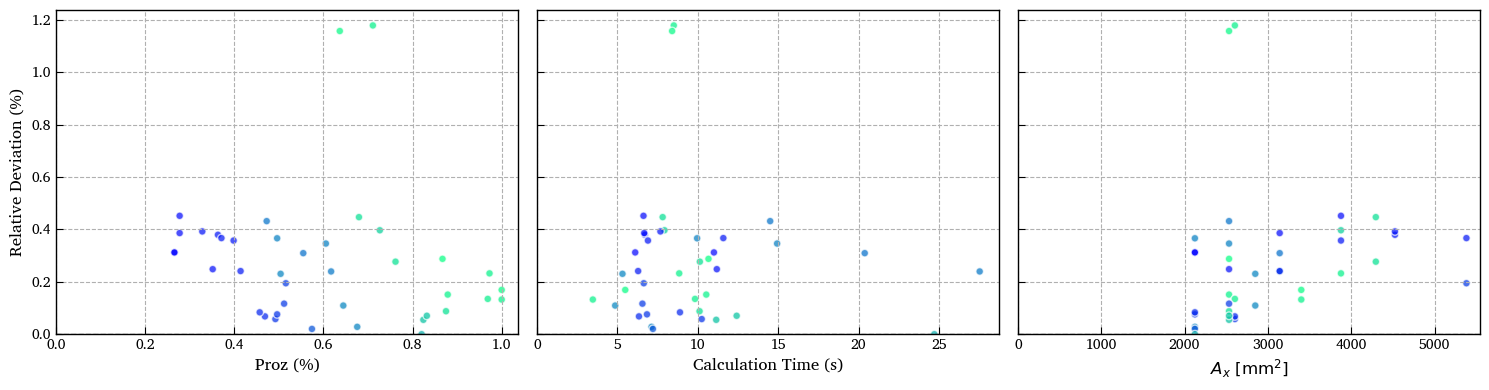

In [396]:
fig, axs = plt.subplots(1, 3, figsize=(15, 4),sharey=True)
axs[0].scatter(df_error['proz'], df_error['rel_deviation'],
               c=df_error['target'], cmap='winter', s=30, edgecolor='white', alpha=0.7)
axs[0].set_xlabel('Proz (%)')
axs[0].set_ylabel('Relative Deviation (%)')

axs[1].scatter(df_error['calculation_time'], df_error['rel_deviation'],
               c=df_error['target'], cmap='winter', s=30, edgecolor='white', alpha=0.7)
axs[1].set_xlabel('Calculation Time (s)')

axs[2].scatter(df_error['A_x'], df_error['rel_deviation'],
               c=df_error['target'], cmap='winter', s=30, edgecolor='white', alpha=0.7)
axs[2].set_xlabel(plot_params.feature_labels['A_x'])

for ax in axs:
    ax.axhline(y=0, color='black', linestyle='--', linewidth=1, alpha=0.5)
    ax.set_ylim(0, None)
    ax.set_xlim(0, None)
    ax.grid(True, linestyle='--', zorder=0)

plt.tight_layout()
plt.show()

In [399]:
import seaborn as sns

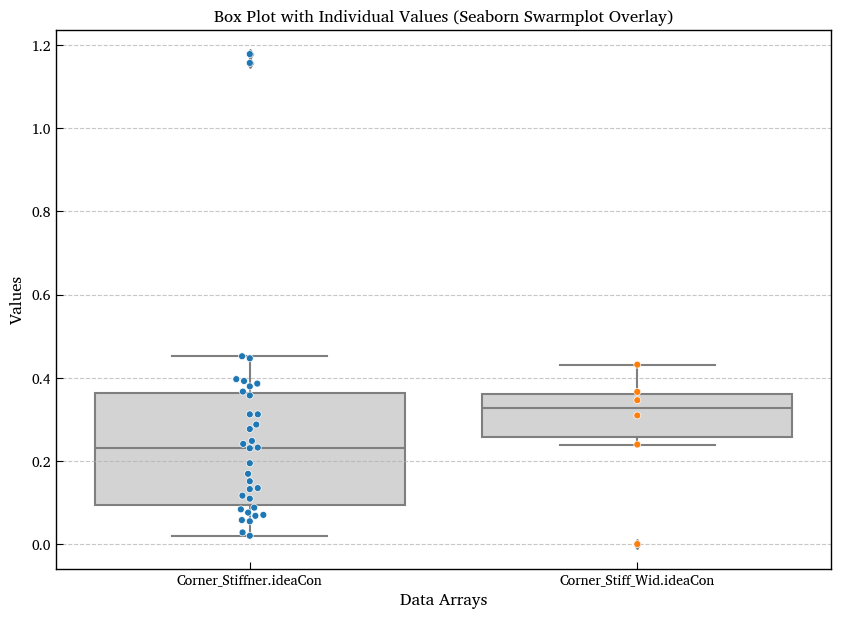

In [400]:
df_long = pd.DataFrame({
    'Value': np.concatenate([df_error[df_error['template'] == ideatemplates_filenames[0]]['rel_deviation'].values, 
                             df_error[df_error['template'] == ideatemplates_filenames[1]]['rel_deviation'].values,
                             df_error[df_error['template'] == ideatemplates_filenames[2]]['rel_deviation'].values,
                             df_error[df_error['template'] == ideatemplates_filenames[3]]['rel_deviation'].values]),
    'Array_Name': [ideatemplates_filenames[0]] * len(df_error[df_error['template'] == ideatemplates_filenames[0]]['rel_deviation'].values) +
                  [ideatemplates_filenames[1]] * len(df_error[df_error['template'] == ideatemplates_filenames[1]]['rel_deviation'].values) +
                  [ideatemplates_filenames[2]] * len(df_error[df_error['template'] == ideatemplates_filenames[2]]['rel_deviation'].values) +
                  [ideatemplates_filenames[3]] * len(df_error[df_error['template'] == ideatemplates_filenames[3]]['rel_deviation'].values)
})

# 3. Create the figure and axes
plt.figure(figsize=(10, 7)) # Adjust figure size as needed

sns.boxplot(x='Array_Name', y='Value', data=df_long, ax=plt.gca(), color='lightgray')

sns.swarmplot(x='Array_Name', y='Value', data=df_long, ax=plt.gca(),
              palette='tab10', edgecolor='white', linewidth=0.5, size=5)

# 6. Add labels and title for better understanding
plt.title('Box Plot with Individual Values (Seaborn Swarmplot Overlay)')
plt.ylabel('Values')
plt.xlabel('Data Arrays')
plt.grid(axis='y', linestyle='--', alpha=0.7) # Add a grid for better readability

# Display the plot
plt.show()

### Correlations

In [401]:
correlations = df_AL[~np.isnan(df_AL['rel_deviation'])].select_dtypes(include='number').corr()['rel_deviation'].sort_values(ascending=False)
print(correlations)

rel_deviation       1.000000
M_contribution      0.606728
M                   0.312419
tw_y                0.178642
A_y                 0.172251
A_x                 0.170334
tf_y                0.155726
tw_x                0.142406
cost                0.141078
Wely_x              0.137848
Wely_y              0.131734
Av_y                0.129076
Av_x                0.123333
tf_x                0.120934
Mpl_x               0.116901
Mpl_y               0.112144
Vpl_y               0.040300
Vpl_x               0.037318
h_wid               0.024464
base_sample_id      0.010584
b_wid               0.002735
calculation_time   -0.060313
tau_x              -0.108386
tau_y              -0.108386
V                  -0.600314
V_contribution     -0.697079
Gamma                    NaN
Offset                   NaN
Offset_Idea              NaN
iteration                NaN
Name: rel_deviation, dtype: float64


#### Uncertainty

In [402]:
mcd_mean, mcd_std, _ = model.mc_dropout_uncertainty(df_added, num_samples=200)
uncertainty_added = mcd_std.flatten() / mcd_mean.flatten()

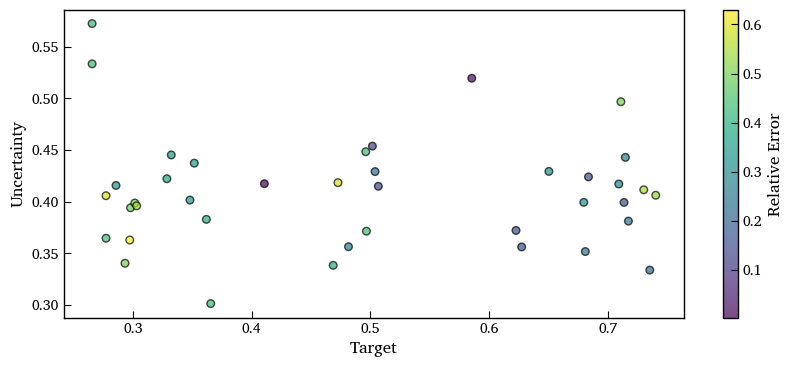

In [403]:
fig, ax = plt.subplots(figsize=(10, 4))

plt.scatter(df_added['target'], uncertainty_added, label='Added Data',
            c=error_added, cmap='viridis', edgecolor='black', s=30, alpha=0.7)

plt.colorbar(label='Relative Error')
plt.xlabel('Target')
plt.ylabel('Uncertainty')
plt.show()

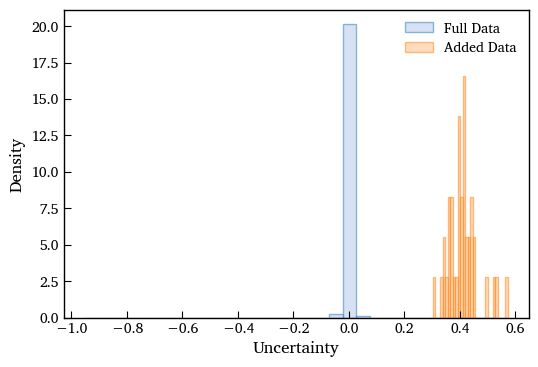

In [404]:
fig, ax = plt.subplots(figsize=(6, 4))

plt.hist(uncertainty_full, bins=30,
         edgecolor=plot_params.morecolors[0], 
         facecolor=plot_params.morecolors[1], 
         alpha=0.5, label='Full Data',
         density=True)

plt.hist(uncertainty_added, bins=30, 
         edgecolor=plot_params.morecolors[2], 
         facecolor=plot_params.morecolors[3], 
         alpha=0.5, label='Added Data',
         density=True)

plt.legend()
plt.xlabel('Uncertainty')
plt.ylabel('Density')

plt.show()

## Global Active Learning

## Preprocessing

### Get necessary variables

Files needed:
- `Saved Variables\hypercubemap.npy` generated by `Feasible_Hypercubemap_Generation`
- `Saved Variables\hypercube_features.json` generated by `Feasible_Hypercubemap_Generation`
- `Saved Models\DNN_Model_Full_V2\DNN_Model_Full_V2.pth` generated by `DNN_FullModel.ipynb`

In [200]:
directory.reset_root()

Root Directory set to:  c:\Users\benja\OneDrive\Desktop\Masterarbeit\Code\10_Neural_Networks


#### Load Hypercubemap

In [201]:
hypercubemap = np.load(r"Saved Variables\hypercubemap.npy")
with open("Saved Variables\hypercube_features.json", "rb") as file: 
        hypercube_features = pickle.load(file)

#### Load Model

In [202]:
model = DNN()

model_name = "DNN_Model_Full_V3"
MODEL_SAVE_PATH = os.path.join("Saved Models", model_name)
MODEL_SAVE_FILE = os.path.join(MODEL_SAVE_PATH, f"{model_name}.pth")
                               
model = torch.load(MODEL_SAVE_FILE)
df = df_full.loc[model.data['data_indeces']]

for key, value in model.config.items():
    print(key, value)

batch_size 256
epochs 2500
learning_rate 0.001
test_size 0.1
val_size 0.1
print_logs True
dropout_prob 0.0
num_layers 3
neurons_per_layer [128, 64, 32, 16, 8]
use_batch_norm True
seed 42
description Different to V2, do not Cat_h & Cath_stiffc features


### Define Functions 

Finds the $n$-dimensional coordinates in the hypercubemap with $m$ bins for a given datapoint.

In [203]:
def find_bins(datapoint, bounds, m):
    bin_widths = (bounds[:, 1] - bounds[:, 0]) / m
    if np.any(datapoint < bounds[:, 0]) or np.any(datapoint > bounds[:, 1]):
        return None
    
    bin_indices = ((datapoint - bounds[:, 0]) / bin_widths).astype(int)
    bin_indices = np.clip(bin_indices, 0, m - 1)
    
    return tuple(bin_indices)

Calculates maximum neighbouring distance over all dimensions and the normalized distance to the next feasible hypercube.

In [204]:
def check_feasibility(datapoint, hypercubemap, bounds, m):
    bin_indices = find_bins(datapoint, bounds, m)

    if bin_indices is None:
        return 'Datapoint is out of bounds'
    
    closest_index = np.argmin(np.sum((hypercubemap - bin_indices) ** 2, axis=1))
    closest_bin = hypercubemap[closest_index]
    error = np.abs(closest_bin - bin_indices)

    feasibilty_degree = np.max(error)

    return feasibilty_degree, np.sum(error)/len(error)

Define the upper and lower bounds of the data and the width of the bins for each dimension.

In [205]:
bounds = np.array([df_full[hypercube_features].min(), df_full[hypercube_features].max()]).T
m = np.max(hypercubemap)
lower_bounds = bounds[:, 0]
bin_widths = (bounds[:, 1] - bounds[:, 0]) / m

Function to sample a datapoint, given a hypercube. Randomly samples a value for each dimension according to a uniform distribution $\mathcal{U}(\mathrm{lower bound}, \mathrm{upper bound})$.

In [206]:
def sample_from_bins(bounds, m, map):
    lower_bounds = bounds[:, 0]
    upper_bounds = bounds[:, 1]
    bin_widths = (upper_bounds - lower_bounds) / m

    bin_starts = lower_bounds + bin_widths * map
    bin_ends = bin_starts + bin_widths

    return np.random.uniform(bin_starts, bin_ends)

Define from what ratio of the Hypercubemap should be sampled from:

In [207]:
ratio = 1.0 # of the hypercube map to sample

n_samples = int(ratio * len(hypercubemap))
print(f"Sampling {n_samples} samples from the hypercube map.")

Sampling 115352 samples from the hypercube map.


## Sample

Select random hypercubes (according to defined ratio `xx%`) and sample a datapoint in each selected hypercube.

In [208]:
sampling_hypercube_ids = random.sample(range(len(hypercubemap)),k=n_samples)
hypercube_samples = np.zeros((n_samples, len(hypercube_features)))

for hypercube_id in sampling_hypercube_ids:
    sampled_point = sample_from_bins(bounds, m, hypercubemap[hypercube_id])
    
    hypercube_samples[hypercube_id] = sampled_point

Define how many load combinations should be considered per sample:

In [209]:
loads_per_curve = 5

Convert the samples to a DataFrame:

In [210]:
df_template = pd.DataFrame(columns=df_full.columns)
df_template = df_template.reindex(range(n_samples * loads_per_curve))

df_hypercube_samples_unique = pd.DataFrame(columns=df_full.columns)
df_hypercube_samples_unique = df_template.reindex(range(n_samples))
df_hypercube_samples_unique[hypercube_features] = hypercube_samples

Add the loads by spreading them equally over the first quadrant. 

In [211]:
df_hypercube_samples = df_template.copy()

df_hypercube_samples[hypercube_features] = np.repeat(hypercube_samples, loads_per_curve, axis=0)

theta = np.linspace(0, np.pi/2, loads_per_curve)

M_contributions = np.cos(theta).round(4)
V_contributions = np.sin(theta).round(4)

df_hypercube_samples['M_contribution'] = np.tile(M_contributions, n_samples)
df_hypercube_samples['V_contribution'] = np.tile(V_contributions, n_samples)

In [212]:
df_hypercube_samples['t_stiffb'] = np.zeros(n_samples * loads_per_curve)

In [213]:
df_hypercube_samples[model.features]

,A_x,Iy_x,Wely_x,Wply_x,fy_x,A_y,Iy_y,Wely_y,Wply_y,fy_y,Gamma,Offset,h_wid,b_wid,d_wid,t_fwid,t_wwid,t_stiffc,V_contribution,M_contribution
0,4703.454618,5.176325e+08,1.040719e+06,3.124010e+05,258.666032,3361.946963,4.562387e+08,2.226917e+05,2.043990e+06,236.151134,0.085236,10.728639,85.898236,75.796630,7.149454,2.274344,2.295207,2.040943,0.0000,1.0000
1,4703.454618,5.176325e+08,1.040719e+06,3.124010e+05,258.666032,3361.946963,4.562387e+08,2.226917e+05,2.043990e+06,236.151134,0.085236,10.728639,85.898236,75.796630,7.149454,2.274344,2.295207,2.040943,0.3827,0.9239
2,4703.454618,5.176325e+08,1.040719e+06,3.124010e+05,258.666032,3361.946963,4.562387e+08,2.226917e+05,2.043990e+06,236.151134,0.085236,10.728639,85.898236,75.796630,7.149454,2.274344,2.295207,2.040943,0.7071,0.7071
3,4703.454618,5.176325e+08,1.040719e+06,3.124010e+05,258.666032,3361.946963,4.562387e+08,2.226917e+05,2.043990e+06,236.151134,0.085236,10.728639,85.898236,75.796630,7.149454,2.274344,2.295207,2.040943,0.9239,0.3827
4,4703.454618,5.176325e+08,1.040719e+06,3.124010e+05,258.666032,3361.946963,4.562387e+08,2.226917e+05,2.043990e+06,236.151134,0.085236,10.728639,85.898236,75.796630,7.149454,2.274344,2.295207,2.040943,1.0000,0.0000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
576755,45034.119564,6.878905e+09,1.408341e+07,1.618498e+07,458.567000,43761.014679,6.745520e+09,1.314043e+07,1.547808e+07,470.197311,0.847389,291.312080,56.525066,3.402091,13.274620,1.026636,1.964037,25.915862,0.0000,1.0000
576756,45034.119564,6.878905e+09,1.408341e+07,1.618498e+07,458.567000,43761.014679,6.745520e+09,1.314043e+07,1.547808e+07,470.197311,0.847389,291.312080,56.525066,3.402091,13.274620,1.026636,1.964037,25.915862,0.3827,0.9239
576757,45034.119564,6.878905e+09,1.408341e+07,1.618498e+07,458.567000,43761.014679,6.745520e+09,1.314043e+07,1.547808e+07,470.197311,0.847389,291.312080,56.525066,3.402091,13.274620,1.026636,1.964037,25.915862,0.7071,0.7071
576758,45034.119564,6.878905e+09,1.408341e+07,1.618498e+07,458.567000,43761.014679,6.745520e+09,1.314043e+07,1.547808e+07,470.197311,0.847389,291.312080,56.525066,3.402091,13.274620,1.026636,1.964037,25.915862,0.9239,0.3827


Get Uncertainty and predicted Target of samples:

In [214]:
mcd_mean_hypercube, mcd_std_hypercube, _ = model.mc_dropout_uncertainty(df_hypercube_samples, num_samples=50)
uncertainty_hypercube = mcd_std_hypercube / mcd_mean_hypercube

y_preds_hypercube, _ = model.predict(df_hypercube_samples)
y_preds_hypercube = y_preds_hypercube.numpy().flatten()

In [215]:
for feature in model.features:
    if feature not in hypercube_features:
        print(feature)

V_contribution
M_contribution


#### Visualize uncertainty across different dimensions

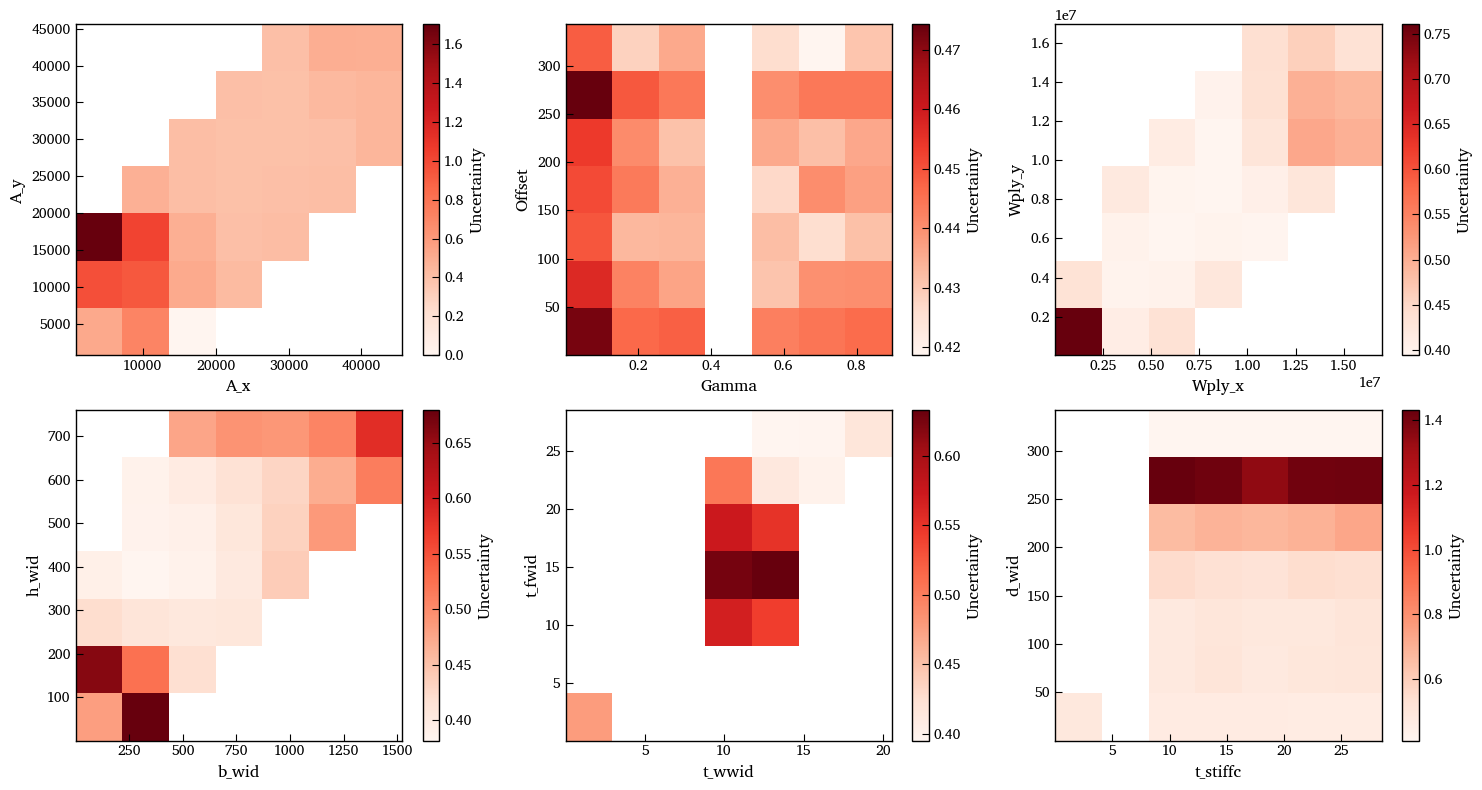

In [216]:
grid_x, grid_y = m, m

fig, axs = plt.subplots(2, 3, figsize=(15, 8))

for i,(x_feature,y_feature) in enumerate(zip(['A_x','Gamma','Wply_x','b_wid','t_wwid','t_stiffc'],['A_y','Offset','Wply_y','h_wid','t_fwid','d_wid'])):
    
    x = df_hypercube_samples[x_feature].values
    y = df_hypercube_samples[y_feature].values
    c = np.clip(uncertainty_hypercube, 0, None).flatten()

    stat, x_edges, y_edges, _ = binned_statistic_2d(
        x, y, c, statistic='median', bins=[grid_x, grid_y]
    )

    X, Y = np.meshgrid((x_edges[:-1] + x_edges[1:]) / 2, 
                    (y_edges[:-1] + y_edges[1:]) / 2)

    pcm = axs[int(i/3),i%3].pcolormesh(X, Y, stat.T, cmap='Reds', shading='auto')

    fig.colorbar(pcm, ax=axs[int(i/3),i%3], label="Uncertainty")

    axs[int(i/3),i%3].set_xlabel(x_feature)
    axs[int(i/3),i%3].set_ylabel(y_feature)

plt.tight_layout()
plt.show()

### Identify critical Data

Identify and select the n most uncertain samples.

In [217]:
n_most_uncertain = 100
most_uncertain_hypercubes = np.argsort(uncertainty_hypercube.flatten())[-n_most_uncertain:]

index_mapping = np.repeat(np.arange(n_samples), loads_per_curve,axis=0)

print(f"{len(np.unique(index_mapping[most_uncertain_hypercubes]))} of {len(most_uncertain_hypercubes)} are unique hypercubes.")

100 of 100 are unique hypercubes.


In [218]:
df_samples = df_hypercube_samples.loc[most_uncertain_hypercubes].copy()

In [219]:
df_samples

,Profile_x,h_x,b_x,tw_x,tf_x,A_x,Av_x,Iy_x,Wely_x,Wply_x,...,M_Rd,V_Rd,V_contribution,M_contribution,V_norm,M_norm,target,Cat_h,Cat_t_stiffc,cost
169491,NaN,396.333561,187.434881,7.945598,11.974250,11771.818411,6226.632981,7.884542e+08,9.954517e+05,8.902217e+05,...,NaN,NaN,0.3827,0.9239,NaN,NaN,NaN,NaN,NaN,NaN
38227,NaN,202.961407,207.067962,6.194348,12.902237,4515.695361,2689.308656,7.221524e+08,5.539519e+05,8.850258e+05,...,NaN,NaN,0.7071,0.7071,NaN,NaN,NaN,NaN,NaN,NaN
44993,NaN,159.831475,203.362563,7.391418,10.253469,4931.004785,2418.415259,5.724961e+08,1.082757e+05,2.889388e+04,...,NaN,NaN,0.9239,0.3827,NaN,NaN,NaN,NaN,NaN,NaN
173112,NaN,466.659037,323.394454,9.022610,17.751435,14107.994189,4822.373707,7.561905e+08,1.154303e+06,5.224968e+05,...,NaN,NaN,0.7071,0.7071,NaN,NaN,NaN,NaN,NaN,NaN
186255,NaN,435.406922,317.979800,8.639855,15.862721,14819.557086,6134.646537,8.480546e+08,1.108504e+06,1.340951e+06,...,NaN,NaN,0.0000,1.0000,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
541339,NaN,1096.062956,312.405888,18.160638,34.603305,35094.577976,19292.313013,5.360915e+09,9.662326e+06,1.207620e+07,...,NaN,NaN,1.0000,0.0000,NaN,NaN,NaN,NaN,NaN,NaN
550376,NaN,1019.826209,307.586736,17.973456,33.411289,38193.796402,18837.896017,5.143645e+09,9.762855e+06,1.173929e+07,...,NaN,NaN,0.3827,0.9239,NaN,NaN,NaN,NaN,NaN,NaN
567280,NaN,1095.180433,331.749318,17.644431,35.009536,39019.130959,20556.470624,6.226102e+09,1.105947e+07,1.436132e+07,...,NaN,NaN,0.0000,1.0000,NaN,NaN,NaN,NaN,NaN,NaN
124123,NaN,275.490056,306.720581,8.174975,14.511350,16858.002478,3829.263032,4.871096e+08,4.780863e+05,2.731256e+05,...,NaN,NaN,0.9239,0.3827,NaN,NaN,NaN,NaN,NaN,NaN


## Postprocessing

### Fill in missing values

Some values have not been directly sample from the hypercubemap, but must be calculated or estimated with the existing data features. The missing values incluse:
- $A_v$: Shear Area
- $A_w$: Area of web

The calculation of both of these requires the radius $r$, which is also not included in the hypercubemap. Therefore, we generate estimate the radiu $r$ from other geometric parameters.  

#### Load normed Geometries

In [220]:
directory.reset_root()
os.chdir(r"AL_API")
c5 = pd.read_excel('C5_Geometrie.xlsx')
geometry_profile = c5.iloc[:, list(range(5)) + [15] + [16] + [20] + [21] + [23]]

Av = c5['Av'].values
tw = c5['tw'].values
h = c5['h'].values
tf = c5['tf'].values
b = c5['b'].values
r = c5['r'].values
A = c5['A'].values

Root Directory set to:  c:\Users\benja\OneDrive\Desktop\Masterarbeit\Code\10_Neural_Networks


### Find Profiles

The sampled values were randomly chosen, hence continuous and generally not corresponding to normed values. Therefore, we identify best matching profile type (e.g. IPE 200) for the geometric parameters, by minimizing the euclidian distances between the samples values and the normed values. Given the profile type, all other geometric values can be looked up in the norm tables. 

In [221]:
features_profiles_normed = ['h', 'b', 'tw', 'tf']
features_profiles_x = ['h_x', 'b_x', 'tw_x', 'tf_x']
features_profiles_y = ['h_y', 'b_y', 'tw_y', 'tf_y']

def find_profile_types(df, c5, features_c5, features_dataframe):
    scaler = StandardScaler()
    X_scaled = scaler.fit_transform(c5[features_c5].values)
    datapoints_scaled = scaler.transform(df[features_dataframe].values)
    distances = euclidean_distances(datapoints_scaled, X_scaled)
    closest_indices = distances.argmin(axis=1)
    return c5.iloc[closest_indices]['Profile'].values

In [222]:
estimated_profiles_x = find_profile_types(df_samples, c5, features_profiles_normed, features_profiles_x)
estimated_profiles_y = find_profile_types(df_samples, c5, features_profiles_normed, features_profiles_y)

df_samples['Profile_x'] = estimated_profiles_x
df_samples['Profile_y'] = estimated_profiles_y

df_samples.reset_index(drop=True, inplace=True)

for i,(profile_x, profile_y) in enumerate(zip(estimated_profiles_x, estimated_profiles_y)):
    df_samples.at[i, 'A_x'] = c5.loc[c5['Profile'] == profile_x, 'A'].values[0]
    df_samples.at[i, 'A_y'] = c5.loc[c5['Profile'] == profile_y, 'A'].values[0]

    df_samples.at[i, 'h_wid'] = c5.loc[c5['Profile'] == profile_x, 'h'].values[0]
    df_samples.at[i, 'b_wid'] = c5.loc[c5['Profile'] == profile_x, 'b'].values[0]

    df_samples.at[i, 'Wply_x'] = c5.loc[c5['Profile'] == profile_x, 'Wply'].values[0]
    df_samples.at[i, 'Wply_y'] = c5.loc[c5['Profile'] == profile_y, 'Wply'].values[0]

    df_samples.at[i, 'Av_x'] = c5.loc[c5['Profile'] == profile_x, 'Av'].values[0]
    df_samples.at[i, 'Av_y'] = c5.loc[c5['Profile'] == profile_y, 'Av'].values[0]

    df_samples.at[i, 'Iy_x'] = c5.loc[c5['Profile'] == profile_x, 'Iy'].values[0]
    df_samples.at[i, 'Iy_y'] = c5.loc[c5['Profile'] == profile_y, 'Iy'].values[0]

    df_samples.at[i, 'Aw_x'] = c5.loc[c5['Profile'] == profile_x, 'Aw'].values[0]
    df_samples.at[i, 'Aw_y'] = c5.loc[c5['Profile'] == profile_y, 'Aw'].values[0]

    df_samples.at[i, 'r_x'] = c5.loc[c5['Profile'] == profile_x, 'r'].values[0]
    df_samples.at[i, 'r_y'] = c5.loc[c5['Profile'] == profile_y, 'r'].values[0]



Clip to closest Steel Grade:

In [223]:
fy = df_full['fy_x'].unique()
tau = np.array([135, 160, 205, 260])

In [224]:
diffs_fy = np.abs(df_samples['fy_x'].values[:, np.newaxis] - fy)
closest_fy_id = np.argmin(diffs_fy, axis=1)
df_samples['fy_x'] = fy[closest_fy_id]
df_samples['tau_x'] = tau[closest_fy_id]

diffs_fy = np.abs(df_samples['fy_y'].values[:, np.newaxis] - fy)
closest_fy_id = np.argmin(diffs_fy, axis=1)
df_samples['fy_y'] = fy[closest_fy_id]
df_samples['tau_y'] = tau[closest_fy_id]

In [225]:
df_samples['Mpl_x'] = df_samples['Wply_x'] * df_samples['fy_x'] / 1_000_000
df_samples['Vpl_x'] = df_samples['Av_x'] * df_samples['tau_x'] / 1000
df_samples['Mpl_y'] = df_samples['Wply_y'] * df_samples['fy_y'] / 1_000_000
df_samples['Vpl_y'] = df_samples['Av_y'] * df_samples['tau_y'] / 1000

#### Clip Design Parameters to normed values

Compare Distribution of Design Variables

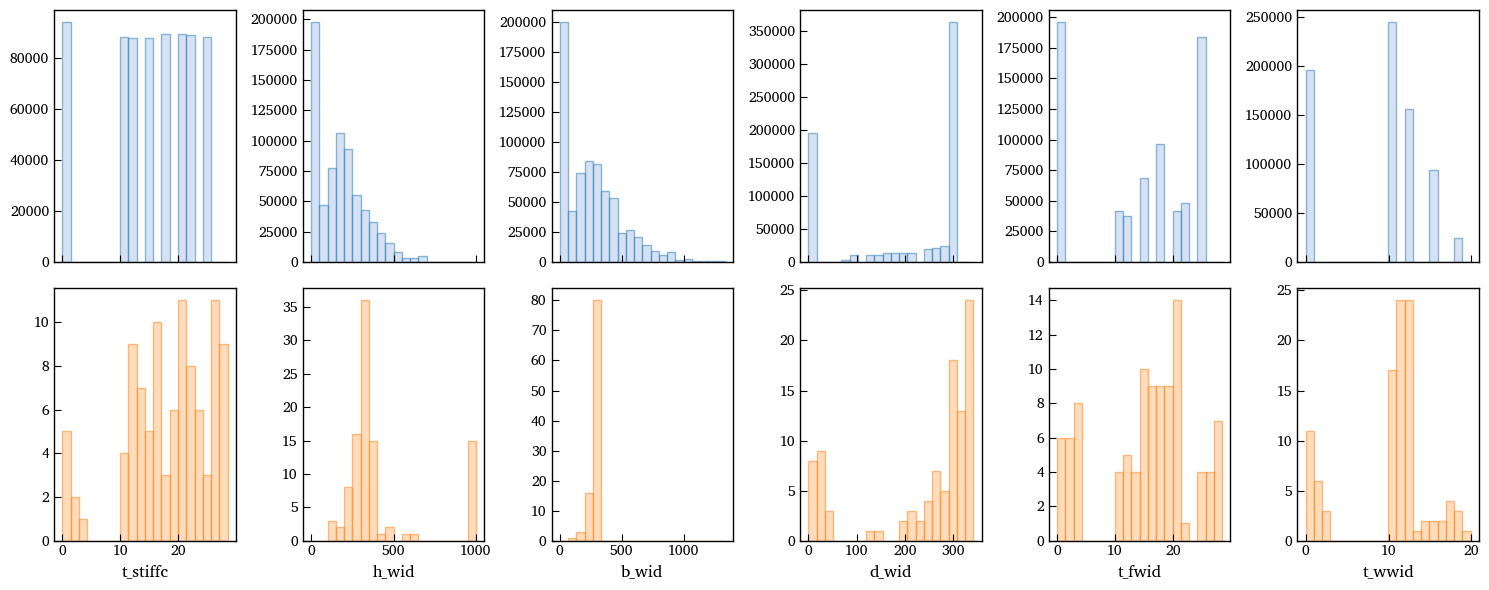

In [226]:
fig, axs = plt.subplots(2, len(variable_features[:-1]), figsize=(15, 6), sharex='col')

for i, feature in enumerate(variable_features[:-1]):
    all_values = np.concatenate([df_full[feature].values, df_samples[feature].values])
    bins = np.histogram_bin_edges(all_values, bins=20)

    ax = axs[0, i]
    ax.hist(df_full[feature].values, bins=bins, 
            edgecolor=plot_params.morecolors[0], 
            facecolor=plot_params.morecolors[1], 
            alpha=0.5)

    ax = axs[1, i]
    ax.hist(df_samples[feature].values, bins=bins, 
            edgecolor=plot_params.morecolors[2], 
            facecolor=plot_params.morecolors[3], 
            alpha=0.5)
    ax.set_xlabel(feature)

plt.tight_layout()
plt.show()

In [227]:
def snap_to_closest(df_samples, df_full, variable_features):
    for col in variable_features[:-1]:
        unique_values = df_full[col].unique()
        diffs = np.abs(df_samples[[col]].values - unique_values[None, :])
        closest_idx = diffs.argmin(axis=1)
        df_samples[col] = unique_values[closest_idx]

In [228]:
snap_to_closest(df_samples, df_full, variable_features[:-1])

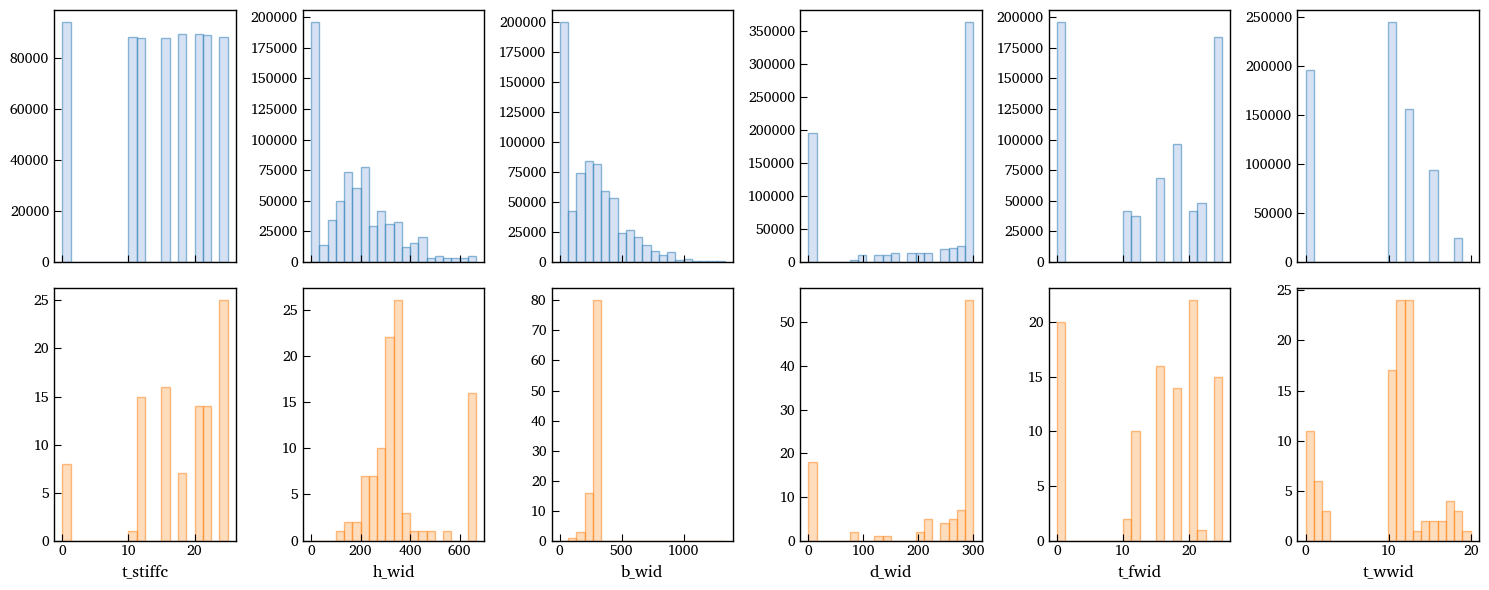

In [229]:
fig, axs = plt.subplots(2, len(variable_features[:-1]), figsize=(15, 6), sharex='col')

for i, feature in enumerate(variable_features[:-1]):
    all_values = np.concatenate([df_full[feature].values, df_samples[feature].values])
    bins = np.histogram_bin_edges(all_values, bins=20)

    ax = axs[0, i]
    ax.hist(df_full[feature].values, bins=bins, 
            edgecolor=plot_params.morecolors[0], 
            facecolor=plot_params.morecolors[1], 
            alpha=0.5)

    ax = axs[1, i]
    ax.hist(df_samples[feature].values, bins=bins, 
            edgecolor=plot_params.morecolors[2], 
            facecolor=plot_params.morecolors[3], 
            alpha=0.5)
    ax.set_xlabel(feature)

plt.tight_layout()
plt.show()

If one parameter of `widener` or `stiffener` equal to 0, set all to 0:

In [230]:
widener_features = ['h_wid', 'b_wid', 'd_wid', 't_fwid', 't_wwid']

for i, sample in df_samples.iterrows():
    if np.any(sample[widener_features] ==0):
        for feature in widener_features:
            df_samples.at[i, feature] = 0.0

#### Get IDEA Templates

In [231]:
idea_templates = []

for i,sample in df_samples.iterrows():
    idea_templates.append(get_ideatemplate(sample))

df_samples['ideatemplate'] = idea_templates

In [232]:
df_samples['ideatemplate'].value_counts()

ideatemplate
Corner_Stiff_Wid.ideaCon    80
Corner_Stiffner.ideaCon     12
Corner.ideaCon               8
Name: count, dtype: int64

#### Get Loads

In [233]:
get_MV(df_samples)

In [234]:
df_samples

,Profile_x,h_x,b_x,tw_x,tf_x,A_x,Av_x,Iy_x,Wely_x,Wply_x,...,M_norm,target,Cat_h,Cat_t_stiffc,cost,Aw_x,Aw_y,r_x,r_y,ideatemplate
0,IPE400,396.333561,187.434881,7.945598,11.974250,8446.357640,4269.457640,2.313000e+08,9.954517e+05,1307000.0,...,NaN,NaN,NaN,NaN,NaN,3323.90,2388.75,21.0,18.0,Corner_Stiffner.ideaCon
1,HEA220,202.961407,207.067962,6.194348,12.902237,6434.123980,2067.123980,5.410000e+07,5.539519e+05,568500.0,...,NaN,NaN,NaN,NaN,NaN,1393.00,1665.00,18.0,18.0,Corner_Stiff_Wid.ideaCon
2,HEA200,159.831475,203.362563,7.391418,10.253469,5383.123980,1808.123980,3.692000e+07,1.082757e+05,429500.0,...,NaN,NaN,NaN,NaN,NaN,1170.00,1665.00,18.0,18.0,Corner_Stiffner.ideaCon
3,HEA360,466.659037,323.394454,9.022610,17.751435,14275.778956,4895.778956,3.309000e+08,1.154303e+06,2088000.0,...,NaN,NaN,NaN,NaN,NaN,3325.00,3444.25,27.0,27.0,Corner_Stiff_Wid.ideaCon
4,HEA340,435.406922,317.979800,8.639855,15.862721,13347.278956,4495.028956,2.769000e+08,1.108504e+06,1850000.0,...,NaN,NaN,NaN,NaN,NaN,2978.25,2650.50,27.0,27.0,Corner_Stiff_Wid.ideaCon
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
95,HEB1000,1096.062956,312.405888,18.160638,34.603305,40004.566612,21248.566612,6.447000e+09,9.662326e+06,14860000.0,...,NaN,NaN,NaN,NaN,NaN,18316.00,18316.00,30.0,30.0,Corner_Stiff_Wid.ideaCon
96,HEB1000,1019.826209,307.586736,17.973456,33.411289,40004.566612,21248.566612,6.447000e+09,9.762855e+06,14860000.0,...,NaN,NaN,NaN,NaN,NaN,18316.00,18316.00,30.0,30.0,Corner_Stiff_Wid.ideaCon
97,HEB1000,1095.180433,331.749318,17.644431,35.009536,40004.566612,21248.566612,6.447000e+09,1.105947e+07,14860000.0,...,NaN,NaN,NaN,NaN,NaN,18316.00,18316.00,30.0,30.0,Corner_Stiff_Wid.ideaCon
98,HEA300,275.490056,306.720581,8.174975,14.511350,11252.778956,3727.778956,1.826000e+08,4.780863e+05,1383000.0,...,NaN,NaN,NaN,NaN,NaN,2346.00,3325.00,27.0,27.0,Corner_Stiff_Wid.ideaCon


## OLD

### Define functions to estimate parameters

#### Estimate radius $r$


Given the normed data the width $b$ has been identified as the strongest correlation to the radius $r$, hence we fit a linear function, which estimates $f(b)=\hat{r}$.

In [ ]:
x = b
y = r

slope, intercept, r_value, p_value, std_err = linregress(x, y)

print(f"Slope: {slope}, Intercept: {intercept}, R^2: {r_value**2}")

Slope: 0.08400521697889492, Intercept: 2.3215160856849337, R^2: 0.9502222132724109


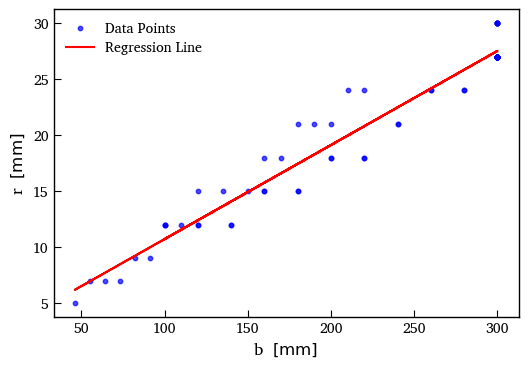

In [107]:
fig, ax = plt.subplots(figsize=(6, 4))
plt.scatter(b,r, label='Data Points', color='blue', s=10, alpha=0.7)
plt.plot(x, slope * x + intercept, color='red', label='Regression Line')

plt.ylabel(r"r  $\mathrm{[mm]}$")
plt.xlabel(r"b  $\mathrm{[mm]}$")

plt.legend()
plt.show()

In [108]:
r_func = lambda b: slope * b + intercept

#### Calculate $A_v$

$$A_v = A-2bt_f+(t_w+2r)t_f$$

In [109]:
Av_calc = df_full['A_x'] - 2 * df_full['b_x'] * df_full['tf_x'] + (df_full['tw_x'] + 2 * r_func(df_full['b_x'].values)) * df_full['tf_x']

Given the existing dataset, quantify the error of this method:

In [110]:
Av_calculation_error = df_full['Av_x'] / Av_calc

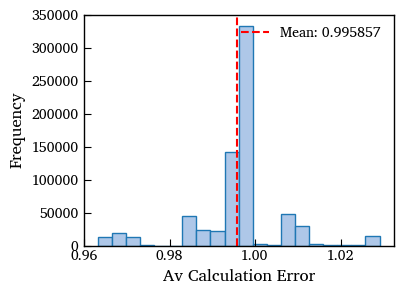

In [111]:
fig, ax = plt.subplots(figsize=(4,3))

plt.hist(Av_calculation_error, bins=20, 
         color=plot_params.morecolors[1], 
         edgecolor=plot_params.morecolors[0],)

plt.axvline(np.mean(Av_calculation_error), color='red', linestyle='--', label=f'Mean: {Av_calculation_error.mean():.6f}')

plt.xlabel('Av Calculation Error')
plt.ylabel('Frequency')
plt.legend()
plt.show()

#### Calculate $A_w$

$$A_w = h\cdot t_w + 4\cdot\hat{r}$$

In [112]:
Aw = h * tw + c5['r'].values*4

### Fill in Data

In [ ]:
df_samples['r'] = r_func(df_samples['b_wid'].values)

In [ ]:
Ax_estimate = (df_samples['h_x']-df_samples['tf_x'])*df_samples['tw_x'] + (4*df_samples['r']**2 - df_samples['r']**2 * np.pi) + 2*df_samples['b_x']*df_samples['tf_x']

In [ ]:
Ay_estimate = (df_samples['h_x']-df_samples['tf_x']) * df_samples['tw_x'] + (4*df_samples['r']**2 - df_samples['r']**2 * np.pi) + 2*df_samples['b_x']*df_samples['tf_x']

In [ ]:
df_samples['A_x'] = Ax_estimate
df_samples['A_y'] = Ay_estimate

#### Calculate $\tau_y$

$$\tau_y=\frac{f_y}{\sqrt{3}}$$

In [ ]:
df_samples['tau _x'] = df_samples['fy_x'] / np.sqrt(3)
df_samples['tau _y'] = df_samples['fy_y'] / np.sqrt(3)

#### Calculate $A_v$

$$A_v=A - 2\cdot b_x \cdot t_f + (t_w + 2\cdot \hat{r})\cdot t_f$$

In [ ]:
df_samples['Av_x'] = df_samples['A_x'] - 2 * df_samples['b_x'] * df_samples['tf_x'] + (df_samples['tw_x'] + 2 * r_func(df_samples['b_x'].values)) * df_samples['tf_x'] 

#### Calculate $V_{pl}$ & $M_{pl}$

In [ ]:
df_samples['Mpl_x'] = df_samples['Wply_x'] * df_samples['fy_x'] / 1000000
df_samples['Vpl_x'] = df_samples['Av_x'] * df_samples['tau_x'] / 1000
df_samples['Mpl_y'] = df_samples['Wply_y'] * df_samples['fy_y'] / 1000000
df_samples['Vpl_y'] = df_samples['Av_y'] * df_samples['tau_y'] / 1000

#### Estimate $M$ & $V$

In [ ]:
get_MV(df_samples)

## Data Generation

In [ ]:
for idea_template in df_samples['ideatemplate'].unique():
    print(idea_templates)
    df_to_add = df_samples[df_samples['ideatemplate'] == idea_templates]

    IdeaName = os.path.join(PATH,idea_template)

    conn = IdeaConnectionClient()
    conn.open(IdeaName)

    print(f'Open IDEA Template: {idea_template}')

    for progress,profile_id in enumerate(list(df_to_add.index)):
        print(f"Progress: {progress / len(df_to_add) * 100:.2f}%")

        params = {
            'Prof_c': df_samples.at[profile_id, 'Profile_x'], 'Prof_b': df_samples.at[profile_id, 'Profile_y'],
            'steel_grade': df_samples.at[profile_id, 'Steel grade_x'], 'gamma': df_samples.at[profile_id, 'Gamma'],
            'h_wid': df_samples.at[profile_id, 'h_wid']/1000, 'b_wid': df_samples.at[profile_id, 'b_wid']/1000,
            'd_wid': df_samples.at[profile_id, 'd_wid']/1000, 't_fwid': df_samples.at[profile_id, 't_fwid']/1000,
            't_wwid': df_samples.at[profile_id, 't_wwid']/1000,
            't_stiffc': df_samples.at[profile_id, 't_stiffc']/1000, 't_stiffb': df_samples.at[profile_id, 't_stiffb']/1000,
            'offset': df_samples.at[profile_id, 'Offset']/1000
        }

        print('      Set Load in Idea')

        conn.update_params_by_name(params)
        if not conn.params_valid():
            raise Exception("Parameters validation failed.")
        
        loads = conn.get_loads()

        loads[0]['forcesOnSegments'][1]['my'] = int(df_samples.at[profile_id,'M']*1000)
        loads[0]['forcesOnSegments'][1]['qz'] = int(df_samples.at[profile_id,'V']*1000)#!!!!

        conn.set_loads(loads) 
        print('      M=',loads[0]['forcesOnSegments'][1]['my'] )
        print('      V=',loads[0]['forcesOnSegments'][1]['qz'] )           

        print('      Calculate...') 
        start_time = time.time()
        calculated = conn.calculate()
        if calculated == False:
            overloaded(calculated,df_samples,profile_id)
        end_time = time.time()

        if calculated == False:
            print(f"Calculation failed for profile {profile_id}.")
            continue

        df_samples.at[profile_id, 'calculation_time'] = end_time - start_time

        results = conn.get_results()
        loads = conn.get_loads()
        applied_percentage = results['analysis']['1']['appliedLoadPercentage']   
        if applied_percentage == 1.0:
            results, loads, applied_percentage = underloaded(applied_percentage,df_samples,profile_id)

        applied_M = applied_percentage * loads[0]['forcesOnSegments'][1]['my']
        applied_V = applied_percentage * loads[0]['forcesOnSegments'][1]['qz']

        df_samples.at[profile_id, 'proz'] = applied_percentage
        df_samples.at[profile_id, 'M_Rd'] = applied_M/1000 # [kNm]
        df_samples.at[profile_id, 'V_Rd'] = applied_V/1000 # [kN]

        cost = results['costEstimationResults']['totalEstimatedCost']
        df_samples.at[profile_id, 'cost'] = cost

    print('   Close Idea')
    conn.close()

calculate_target_from_Rd(df_samples)

['Corner_Stiffner.ideaCon', 'Corner_Stiff_Wid.ideaCon', 'Corner_Stiffner.ideaCon', 'Corner_Stiff_Wid.ideaCon', 'Corner_Stiff_Wid.ideaCon', 'Corner_Stiff_Wid.ideaCon', 'Corner.ideaCon', 'Corner_Stiff_Wid.ideaCon', 'Corner_Stiff_Wid.ideaCon', 'Corner_Stiff_Wid.ideaCon', 'Corner_Stiff_Wid.ideaCon', 'Corner_Stiff_Wid.ideaCon', 'Corner_Stiffner.ideaCon', 'Corner.ideaCon', 'Corner_Stiffner.ideaCon', 'Corner_Stiff_Wid.ideaCon', 'Corner_Stiff_Wid.ideaCon', 'Corner_Stiff_Wid.ideaCon', 'Corner_Stiff_Wid.ideaCon', 'Corner_Stiff_Wid.ideaCon', 'Corner_Stiff_Wid.ideaCon', 'Corner_Stiffner.ideaCon', 'Corner_Stiff_Wid.ideaCon', 'Corner_Stiff_Wid.ideaCon', 'Corner_Stiff_Wid.ideaCon', 'Corner.ideaCon', 'Corner_Stiff_Wid.ideaCon', 'Corner.ideaCon', 'Corner_Stiff_Wid.ideaCon', 'Corner_Stiff_Wid.ideaCon', 'Corner_Stiff_Wid.ideaCon', 'Corner_Stiff_Wid.ideaCon', 'Corner_Stiff_Wid.ideaCon', 'Corner_Stiff_Wid.ideaCon', 'Corner_Stiff_Wid.ideaCon', 'Corner_Stiff_Wid.ideaCon', 'Corner_Stiff_Wid.ideaCon', 'Corner_

In [ ]:
df_samples.to_csv(os.path.join(directory.root, r'Data\GAL_Generated_Data.csv'), index=False)

,Profile_x,h_x,b_x,tw_x,tf_x,A_x,Av_x,Iy_x,Wely_x,Wply_x,...,M_contribution,V_norm,M_norm,target,Cat_h,Cat_t_stiffc,cost,ideatemplate,Mmax,Vmax
89490,None,267.735476,311.377334,10.386557,21.128687,12128.491632,3852.832142,5.195952e+08,3.516126e+06,3.412910e+05,...,1.0,None,None,None,1.042126,1.036205,960.596115,Corner_Stiff_Wid.ideaCon,236.191411,558.664669
90455,None,324.885698,321.777862,12.111239,19.613625,14792.308292,4930.179370,6.795741e+07,3.453771e+06,9.662765e+05,...,1.0,None,None,None,1.033816,1.074467,683.304415,Corner_Stiff_Wid.ideaCon,256.758236,675.301656
120629,None,385.270419,302.417818,12.334466,16.528509,12691.897673,5058.725140,3.477871e+08,3.085818e+06,1.634738e+06,...,0.5,None,None,None,1.034351,1.119202,797.132707,Corner_Stiff_Wid.ideaCon,475.153338,933.914248
29657,None,118.122394,201.012075,6.649391,9.965282,3563.524531,817.002092,1.280801e+08,1.754655e+06,1.444259e+06,...,1.0,None,None,None,1.048311,1.112972,897.145108,Corner_Stiff_Wid.ideaCon,546.241237,676.527527
116213,None,367.072801,309.786550,12.213097,14.225329,14180.328462,5787.157548,3.173656e+08,3.208289e+06,1.389522e+06,...,1.0,None,None,None,1.093799,1.007965,1171.295175,Corner_Stiff_Wid.ideaCon,357.760912,872.079726
89362,None,258.499231,326.201980,11.860005,19.740813,12449.115734,5719.475387,9.003381e+07,3.011360e+06,1.313741e+05,...,1.0,None,None,None,1.099776,1.017943,1492.264876,Corner_Stiff_Wid.ideaCon,478.064131,888.015088
59182,None,236.219110,271.879316,7.812025,9.760639,6703.967824,3269.346164,4.477399e+08,1.750448e+06,6.245225e+05,...,1.0,None,None,None,0.115846,0.129617,198.430192,Corner_Stiff_Wid.ideaCon,599.282657,1170.204199
93761,None,218.985329,314.764041,11.255313,20.012484,15464.802151,6239.718493,7.146613e+07,2.903910e+06,6.904788e+05,...,1.0,None,None,None,1.038094,1.003370,484.150808,Corner_Stiff_Wid.ideaCon,192.772441,1044.472199
92458,None,301.057186,302.699345,11.193675,18.704416,14112.001168,5039.290303,3.550768e+08,3.204865e+06,1.208964e+06,...,1.0,None,None,None,1.037773,1.095470,625.973324,Corner_Stiff_Wid.ideaCon,340.009207,953.129506
55436,None,287.059724,299.400827,6.442034,13.176127,9420.992599,983.537438,3.617923e+07,8.954014e+05,1.756225e+06,...,1.0,None,None,None,1.097152,1.120290,995.413934,Corner_Stiff_Wid.ideaCon,678.478911,835.342276
